In [1]:
import os
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.dates
import matplotlib.dates as mdates

import datetime
from IPython.display import Audio, display, clear_output
from scipy import signal
from scipy.io import wavfile
import pandas as pd
from pydub import AudioSegment

%matplotlib inline

# Sets default style and font parameters for the plots we are making.
mpl.rcParams['font.size']      = 16
mpl.rcParams['font.weight']    = 'bold'
mpl.rcParams['axes.grid']      = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['figure.figsize'] = (12,9)
mpl.rcParams['axes.xmargin']   = 0
mpl.rcParams['axes.ymargin']   = 0.1

c:\Users\alexp\anaconda3\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


### Allows us to constantly iterate through each wav_list in the respective directory

In [2]:
def obtain_wav_list(directory):
    wav_list = []
    for filename in os.listdir(directory):
        f = directory+'/'+filename
        if os.path.isfile(f):
            wav_list.append(f)
    return wav_list

# Must be converted into a singe channel otherwise known as Mono

In [3]:
def convert_to_single_channel(file_list):
    for wave_file in file_list:
        path  = wave_file
        sound = AudioSegment.from_wav(path)
        sound = sound.set_channels(1)
        sound.export(path, format="wav")

# Loads the .wav file and subsequently uses the scipy library to convert it into both a signal representation and get the sampling frequency, from there we normalize the signal and compute the time vector. 

In [4]:
def load_wav(fname,normalize=True):
    # Load WAV file.
    fs,x0 = wavfile.read(fname)
    
    if normalize:
        x0   = x0/float(np.max(np.abs(x0)))

    # Compute time vector.
    N  = len(x0)             # Number of samples in signal
    k  = np.arange(len(x0))  # Integer time vector
    Ts = 1/fs                # Sampling Period
    t  = k*Ts
    
    df = pd.DataFrame({'time':t,'x':x0})
    df = df.set_index('time')
    
    return df, fs  

### load the wav file, apply both a high and low pass freq param that will be used when we take envelope

In [5]:
def filter(filepath,low_pass_freq=250,high_pass_freq=10,):
    x0,fs  = load_wav(filepath)
    # Square the signal.
    x1  = x0**2
    # Compute envelope using a rolling max function.
    Tc  = 1.2e-3 # Rolling Max Window [seconds]
    env = x1.rolling(int(Tc*fs),center=True).max()
    env = env.dropna() # Drop NaNs
    
    wp    = low_pass_freq
    ws    = 1.1*wp

    gpass =  3 # The maximum loss in the passband (dB).
    gstop = 40 # The minimum attenuation in the stopband (dB).
     
    N, Wn = signal.buttord(wp, ws, gpass, gstop, fs=fs)
    sos   = signal.butter(N, Wn, 'low', fs=fs, output='sos')

    env_1      = env.copy()
    env_1['x'] = signal.sosfiltfilt(sos,env['x'])
    if high_pass_freq!=0:
        wp    = high_pass_freq
        ws    = 0.8*wp

        gpass =  3 # The maximum loss in the passband (dB).
        gstop = 40 # The minimum attenuation in the stopband (dB).

        N, Wn = signal.buttord(wp, ws, gpass, gstop, fs=fs)
        sos   = signal.butter(N, Wn, 'high', fs=fs, output='sos')

    env_2      = env_1.copy()
    env_2['x'] = signal.sosfiltfilt(sos,env_1['x'])
    
    return env_2, fs

### Finds the respective chirps in the .wav file, Gerard made it so that now we find the maximum correlation and simply sort them out for analysis. For example, instead of providing a sample for where the PN burst is, we give a sample of one chirp showing clean modulation and for the purposes of the April 8 2024 eclipse, find the closes 10 peaks

In [6]:
def find_chirps(wavlist,sample,plot_correlation=False):
    sample_env,sample_fs = load_wav(sample)
    sample=sample_env['x']

#Here we are effectively taking time components
    chirps_x = []
    chirps_y = []
    wav_data = []

    for file in wavlist:
        wav_env,wav_fs = load_wav(file)

        y = signal.correlate(wav_env['x'],sample,mode='same')
        x = np.arange(0,len(y),1)

        peaks = signal.find_peaks(y, distance=300)[0] 
        local_peaks = pd.DataFrame({'x':x[peaks], 'y':y[peaks]})
        local_peaks = local_peaks.sort_values(by='y',ascending=False)

        cx = local_peaks['x'][0:10].sort_index().values
        cy = local_peaks['y'][0:10].sort_index().values

        chirps_x.append(cx)
        chirps_y.append(cy)
        wav_data.append(wav_env)
        
        if plot_correlation:
            fig = plt.figure(figsize=(16,9))
            ax = fig.add_subplot(1,1,1)
            ax.plot(wav_env.index,wav_env['x'])
            for i in range(0,10):
                x0 = cx[i]/wav_fs
                y0 = cy/float(np.max(np.abs(cy)))
                ax.plot([x0,x0],[-y0,y0],color='tab:orange')
            ax.set_xlim(cx[0]/sample_fs-2.5,cx[-1]/sample_fs+2.5)
            ax.set_title(file)
            plt.show()
            plt.close(fig)
            # clear_output(wait=True)
        else:
            print(file, end = "\r")
    chirps = pd.DataFrame({'file':wavlist,'data':wav_data,'x':chirps_x, 'y':chirps_y})
    return chirps 

In [7]:
def find_max(freq,X_psd,minfreq,maxfreq):
    peaks = signal.find_peaks(X_psd)[0]
    # print(peaks)
    local_peaks = pd.DataFrame({'f':freq[peaks],'X_psd':X_psd[peaks]})#,'x':f[peaks], 'y':X_psd[peaks]})
    local_peaks = local_peaks.sort_values(by='X_psd',ascending=False)
    
    local_peaks_x = local_peaks.f[local_peaks.f>minfreq][local_peaks.f<maxfreq].values#[local_peaks.X_psd > (0.5 * 10**-5)].values
    local_peaks_y = local_peaks.X_psd[local_peaks.f>minfreq][local_peaks.f<maxfreq].values#[local_peaks.X_psd > (0.5 * 10**-5)].values
    
    if len(local_peaks_x)>0:
        maximum_x = local_peaks_x[0]
        maximum_y = local_peaks_y[0]
    else: 
        maximum_x=np.nan
        maximum_y=np.nan
        
    return maximum_x, maximum_y, local_peaks_x, local_peaks_y

# This method takes the FFT of the sorted chirps we found above after doing correlation

In [8]:
def chirp_fft(df,title=None,tlim=None,flim=None,
                 plot_fft=False, minfreq=0,maxfreq=10000):
   
    x    = df['x']
    tvec = df.index
    Ts   = tvec[1] - tvec[0]
    Fs   =1/Ts

    if tlim is None:
        tlim = (0,np.max(tvec))
    elif tlim is not None:
        tf  = np.logical_and(tvec >= tlim[0],
                                tvec <  tlim[1])
        xt  = x[tf].copy()
        
    han_win = np.hanning(len(xt))
    x_han   = han_win*xt
    nfft    = len(x_han)
    if nfft < 2**16: 
        nfft = 2**16

    X_psd   = np.abs(np.fft.fftshift(np.fft.fft(x_han,n=nfft)*Ts*2))**2
    f       = np.fft.fftshift(np.fft.fftfreq(nfft,Ts))

    if plot_fft==True:
        if maxfreq==0:
            maxfreq=10000
        flim = (0,maxfreq)

        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(2,1,1)
        ax.set_title(title)
        bx = fig.add_subplot(2,1,2)
        bx.plot(tvec,x)
        bx.set_xlim(tlim)
        ax.set_ylim(0,10*10**-5)

        ax.plot(f,X_psd)

        maximum_x, maximum_y, local_peaks_x, local_peaks_y = find_max(f,X_psd,minfreq,maxfreq)
        
        ax.plot([maximum_x,maximum_x],[0,maximum_y],linewidth=2)
        ax.plot([0,maximum_x],[maximum_y,maximum_y],linewidth=2, color='red')

        ax.plot([minfreq,minfreq],[0,maximum_y],linewidth=3, color='black')

        ax.scatter(maximum_x,maximum_y,linewidths=5,label=str(maximum_x)[:5]+" Hz",color='green')
        ax.scatter(local_peaks_x,local_peaks_y, color='black')

        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('PSD')
        ax.set_xlim(flim)
        ax.legend()

        ax2 = ax.twiny()
        ax2.xaxis.set_ticks_position("bottom")
        ax2.xaxis.set_label_position("bottom")
        ax2.spines["bottom"].set_position(("axes", -0.15))
        ax2.set_frame_on(True)
        ax2.patch.set_visible(False)
        newlabels = np.arange(0,flim[1]+1,flim[1]/12)
        ax2.set_xticks(np.arange(0,len(newlabels)))
        ax2.set_xticklabels(newlabels/minfreq)
        ax2.ticklabel_format()
        ax2.set_xlabel('TDOA [ms]')
        
        plt.tight_layout()
        clear_output(wait=True)
        plt.show()
        plt.close(fig)

    return X_psd, f

### We finally find TDOAs by finding the maximum frequency in the freq domain and simply dividing it by 10Hz (the sweep rate)

In [9]:
def find_TDOAs(wav_data,limits,filter_limts,plot_fft=False):
    all_beats = []
    for file_num in wav_data.index:
        maxes= []
        fpath = wav_data['file'][file_num]
        wav_env, wav_fs = filter(fpath,filter_limts[1],filter_limts[0])  

        for peak in wav_data['x'][file_num]: 
            peak = peak/wav_fs
            tlim = (peak+limits[0],peak+limits[1])
            minfreq=limits[2]
            maxfreq=limits[3]
            
            X_psd, freq = chirp_fft(wav_env,title=fpath,tlim=tlim, 
                                plot_fft=plot_fft,
                                minfreq = minfreq, maxfreq = maxfreq)
            
            maximum_x, maximum_y, local_peaks_x, local_peaks_y = find_max(freq,X_psd,minfreq,maxfreq)
            
            maxes.append(maximum_x)
            print(fpath, end = "\r")
        all_beats.append(np.array(maxes).flatten())
    TDOAs = np.array(all_beats)/10
    return TDOAs

### Library housing the different directories

In [10]:
directory_40m = '40M_TX-WA5FRF_RX-N5DUP_318km'
directory_60m = '60M_TX-WA5FRF_RX-N5DUP_318km'
directory_scranton = '20M_TX-N5DUP_RX-W3USR_2236km'
directory_40mSam ='40mAB5YO'
directory_60mSam = '60mAB5YO'
directory_20m = '20M_TX-N5DUP_RX-KD2NQV_2236km'
directory_40mN6RFM5 = 'N6RFM5 TDOA Experiment 8April24'
directory_AG5 = 'AG5HR'

wavlist_40m = obtain_wav_list(directory_40m)
wavlist_60m = obtain_wav_list(directory_60m)
wavlist_scranton = obtain_wav_list(directory_scranton)
wavlist_40mSam = obtain_wav_list(directory_40mSam)
wavlist_60mSam = obtain_wav_list(directory_60mSam)
wavlist_20m = obtain_wav_list(directory_20m)
wavlist_40mN6RFM5 = obtain_wav_list(directory_40mN6RFM5)
wavlist_AG5 = obtain_wav_list(directory_AG5)

convert_to_single_channel(wavlist_40m)
convert_to_single_channel(wavlist_60m)
convert_to_single_channel(wavlist_scranton)
convert_to_single_channel(wavlist_40mSam)
convert_to_single_channel(wavlist_60mSam)
convert_to_single_channel(wavlist_20m)
convert_to_single_channel(wavlist_40mN6RFM5)
convert_to_single_channel(wavlist_AG5)

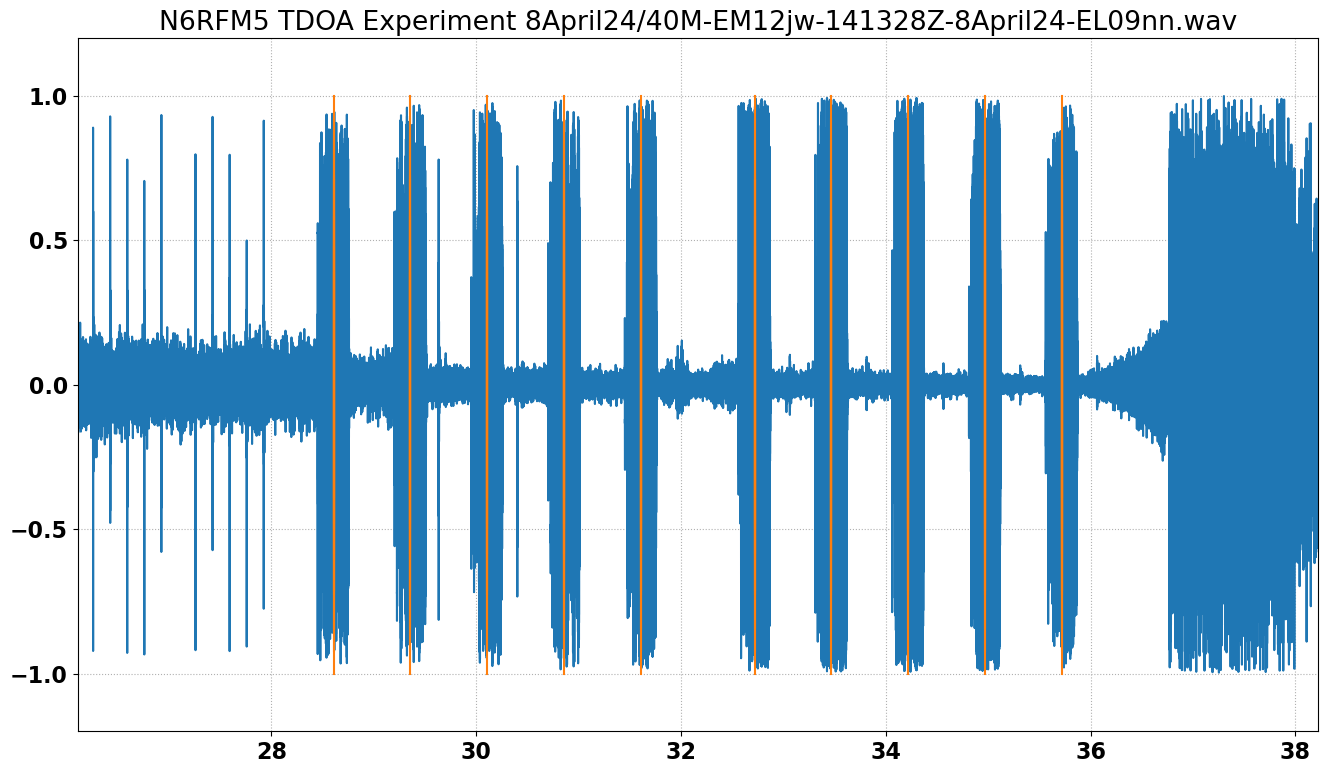

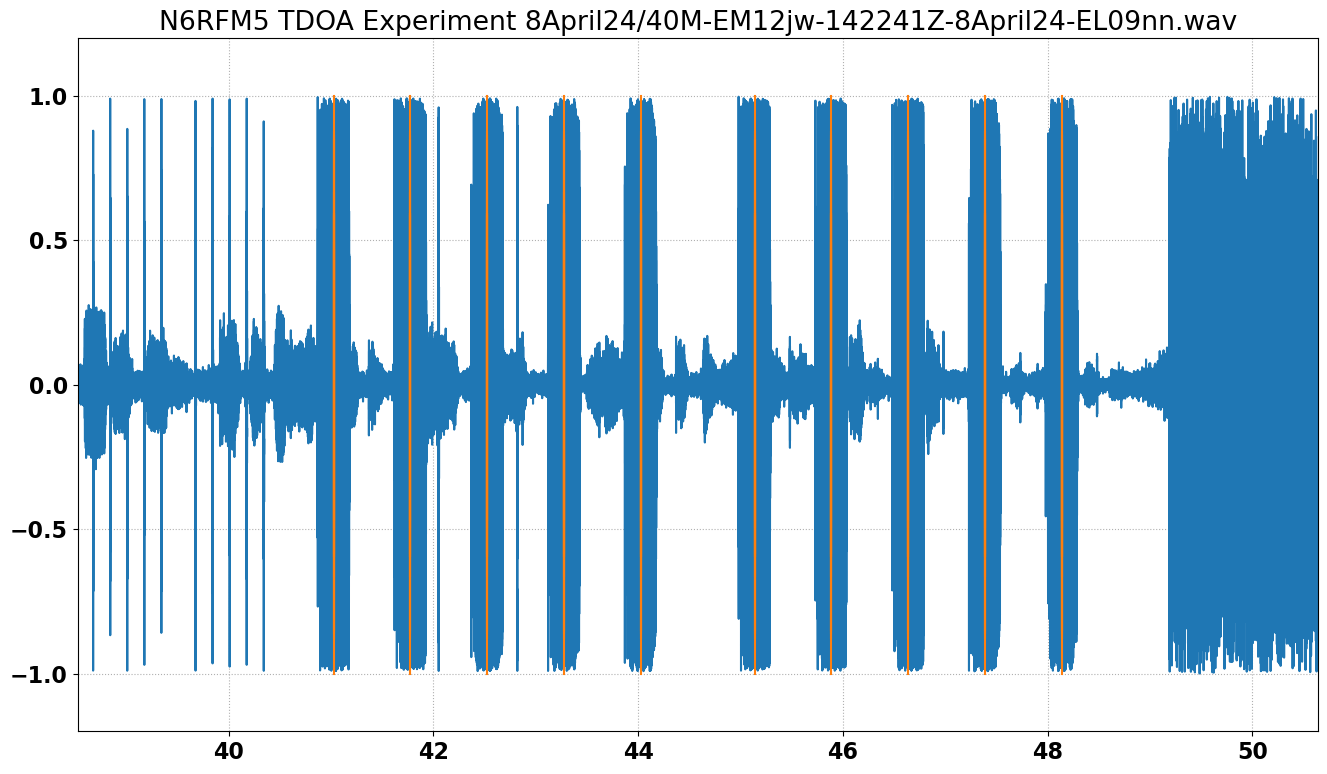

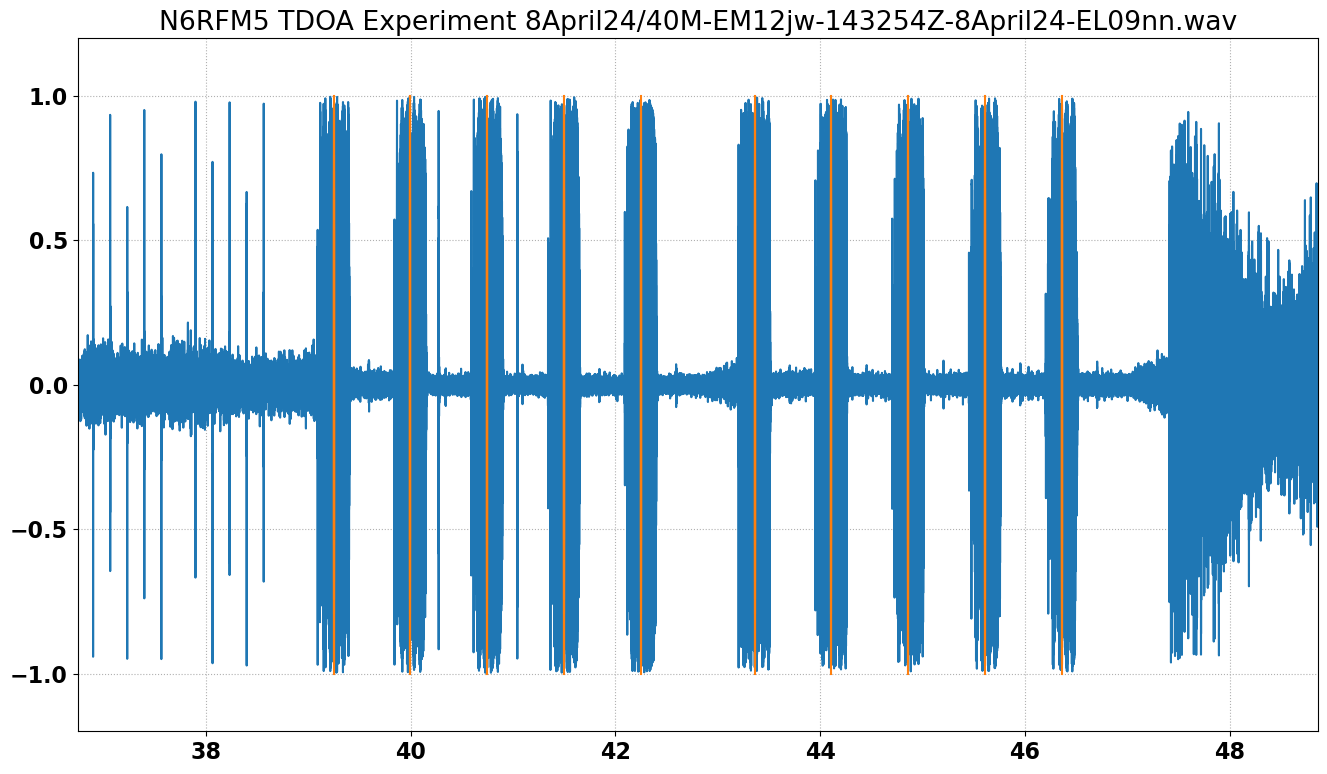

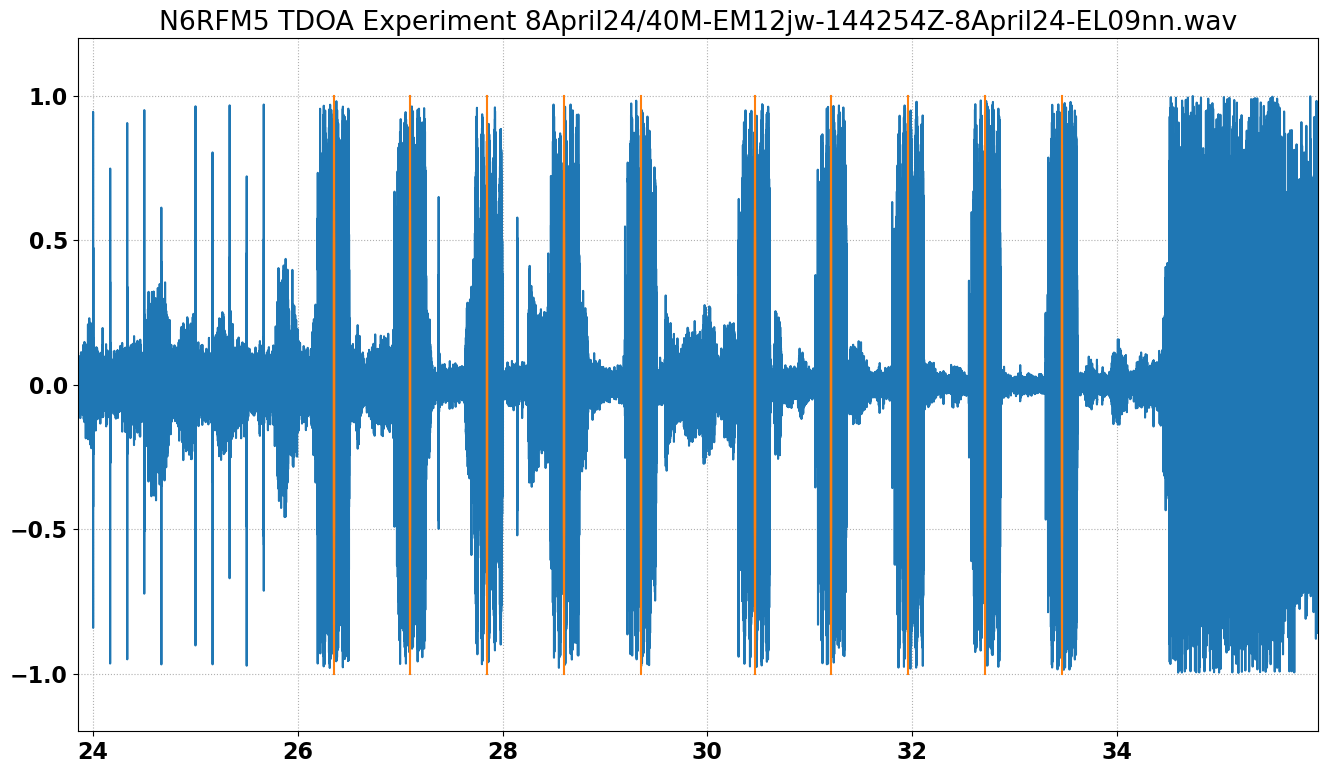

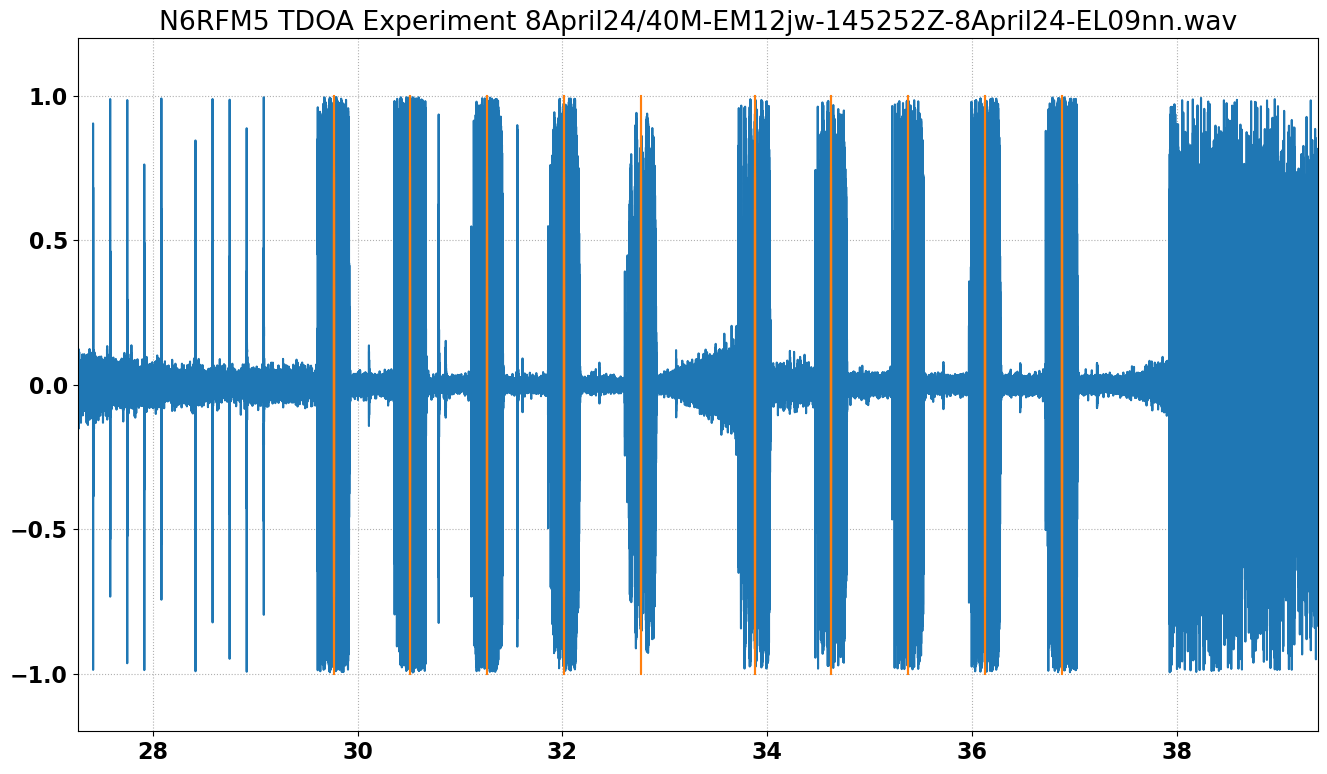

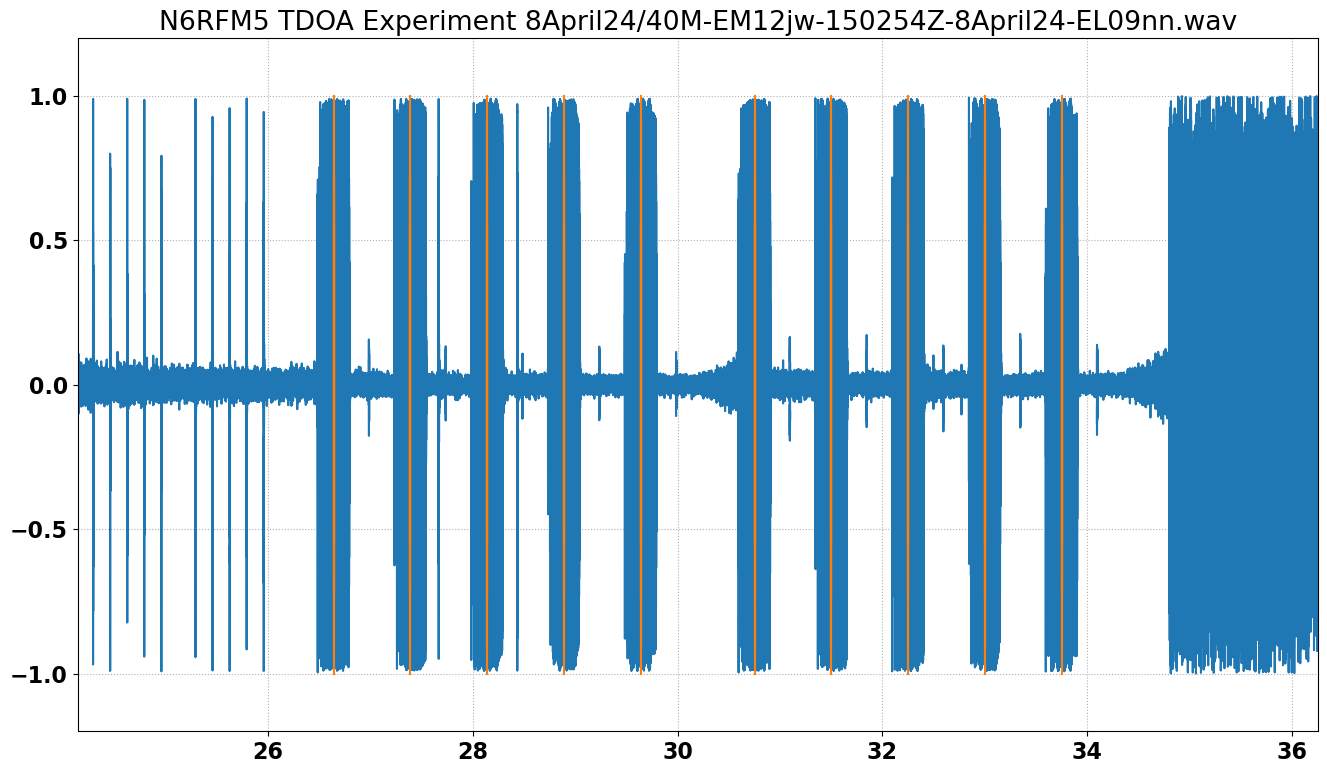

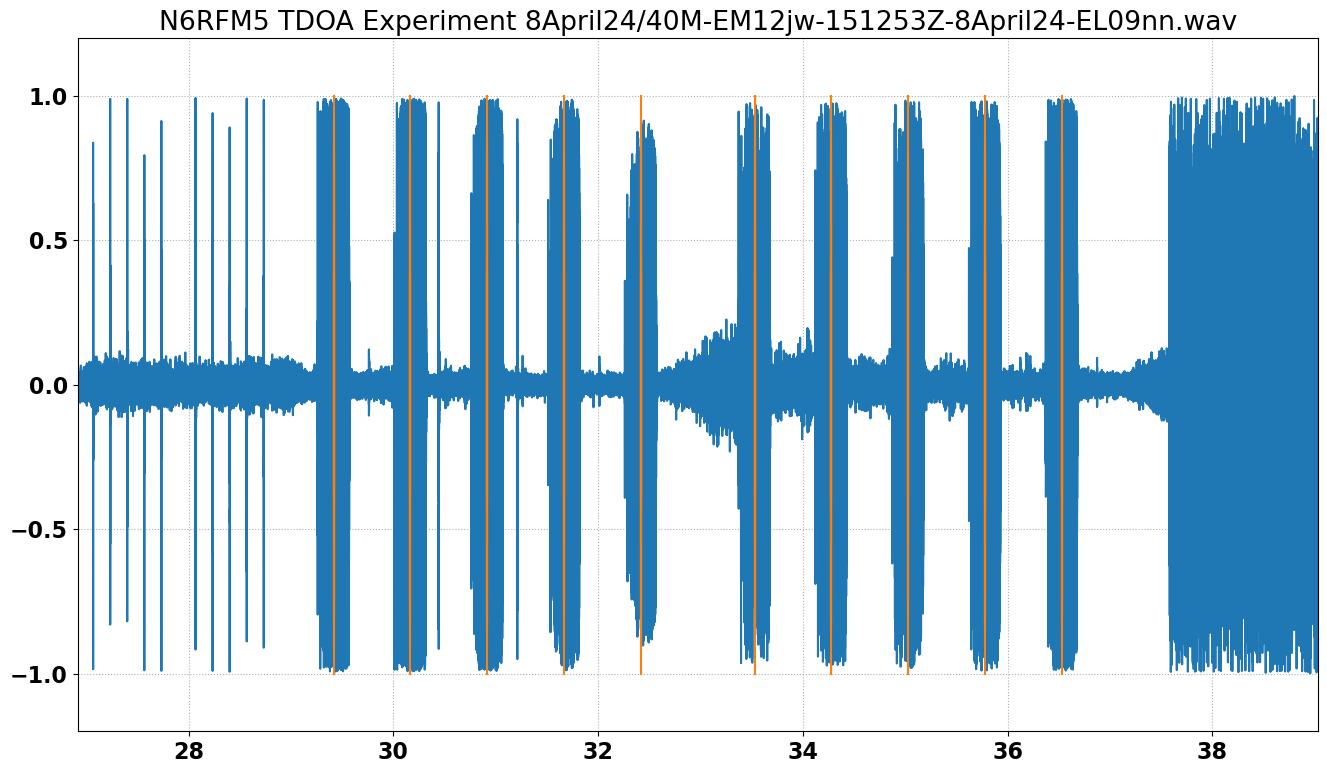

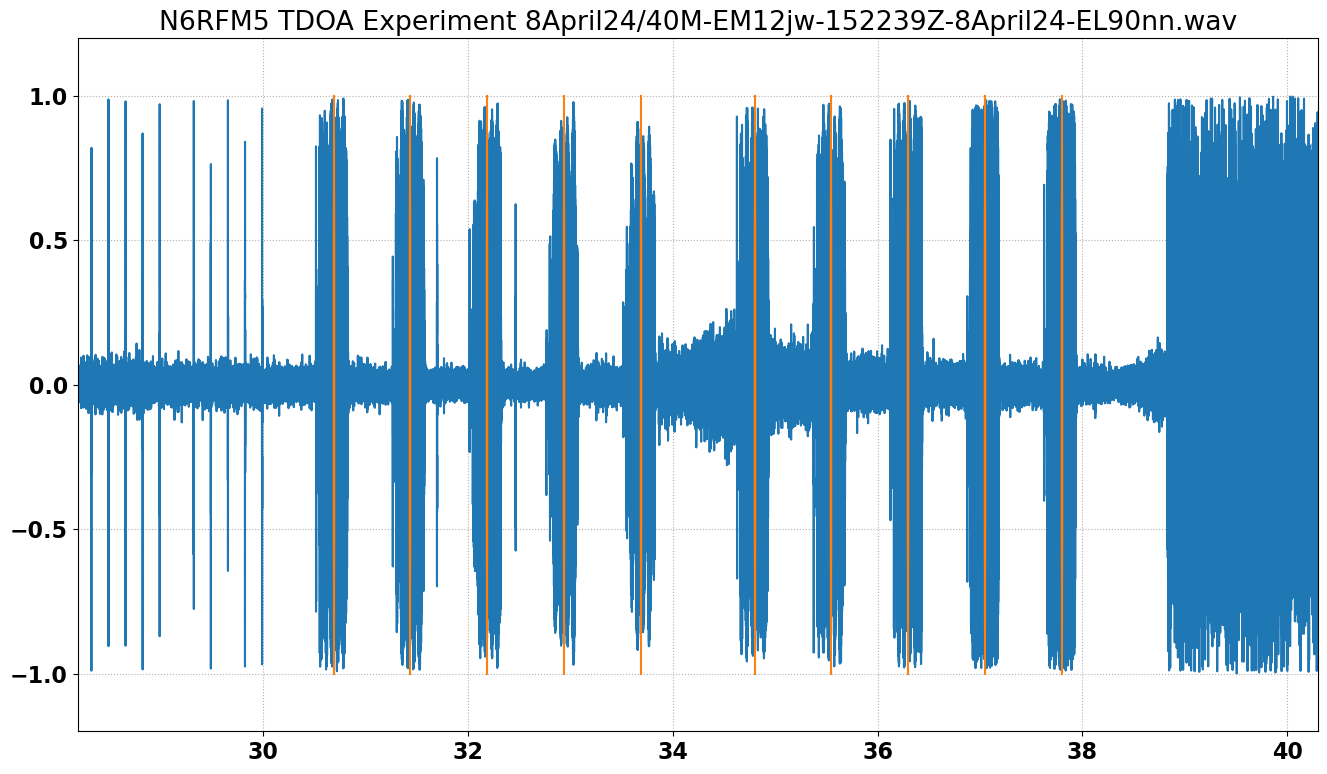

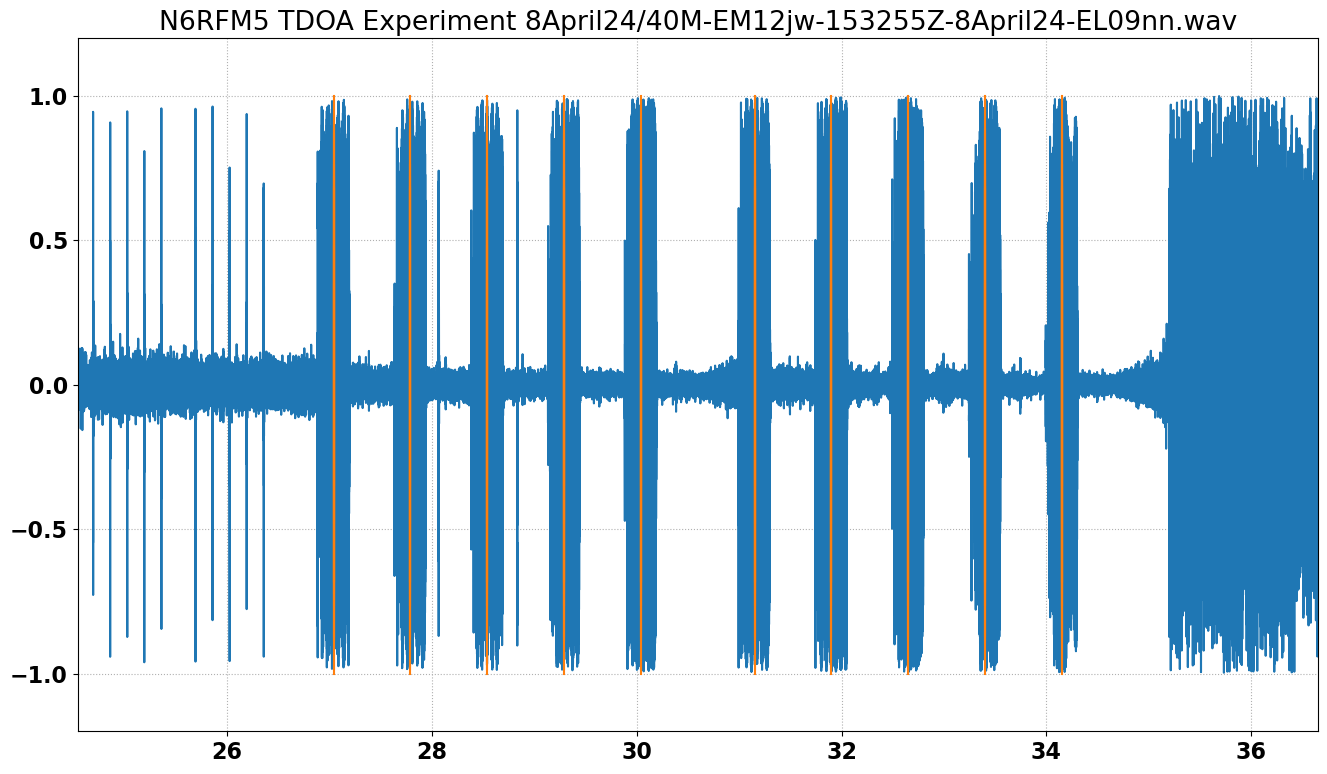

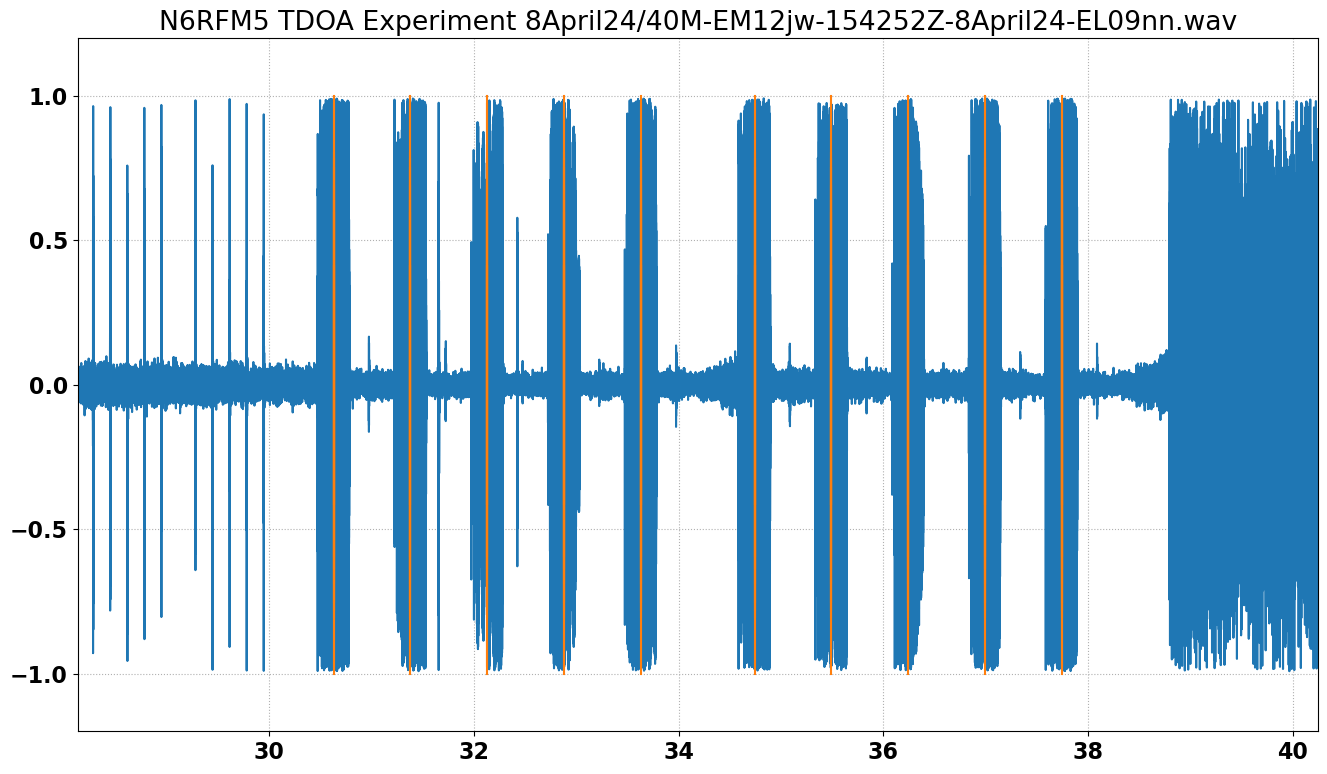

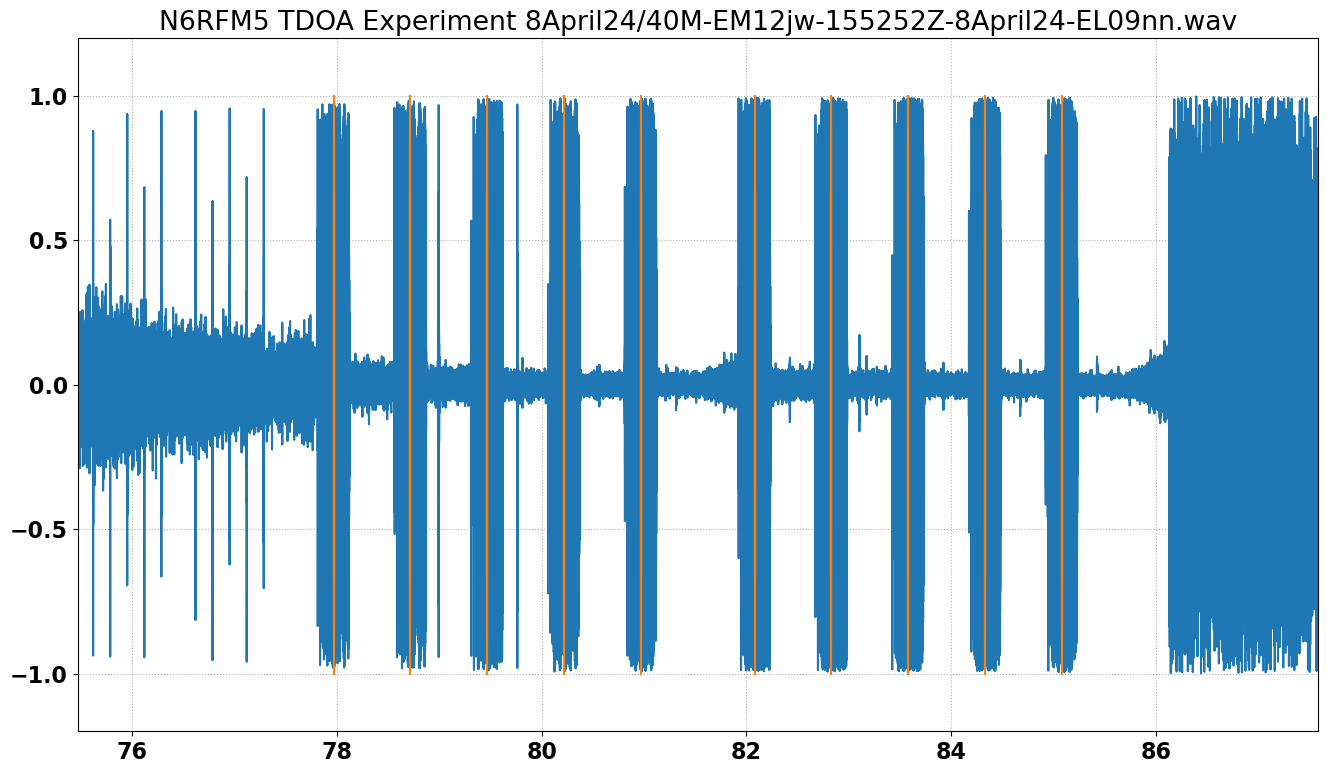

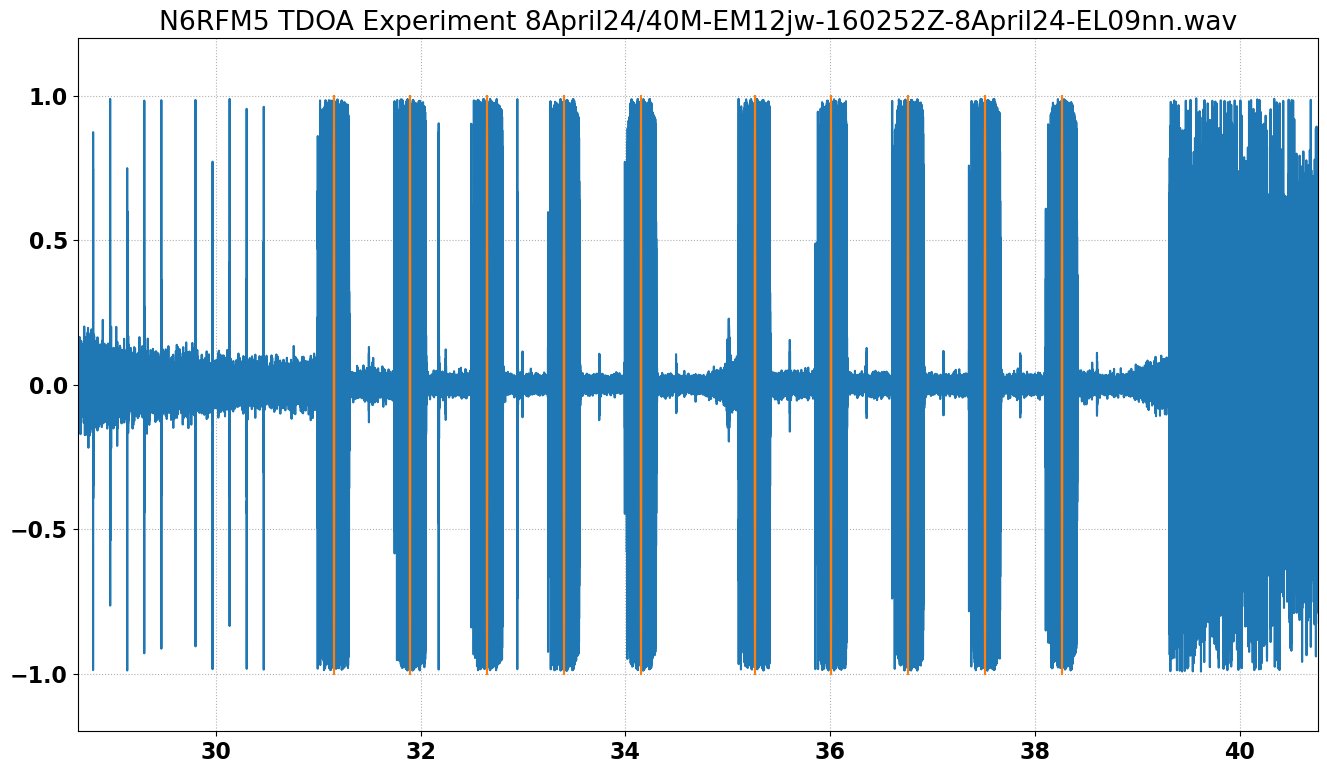

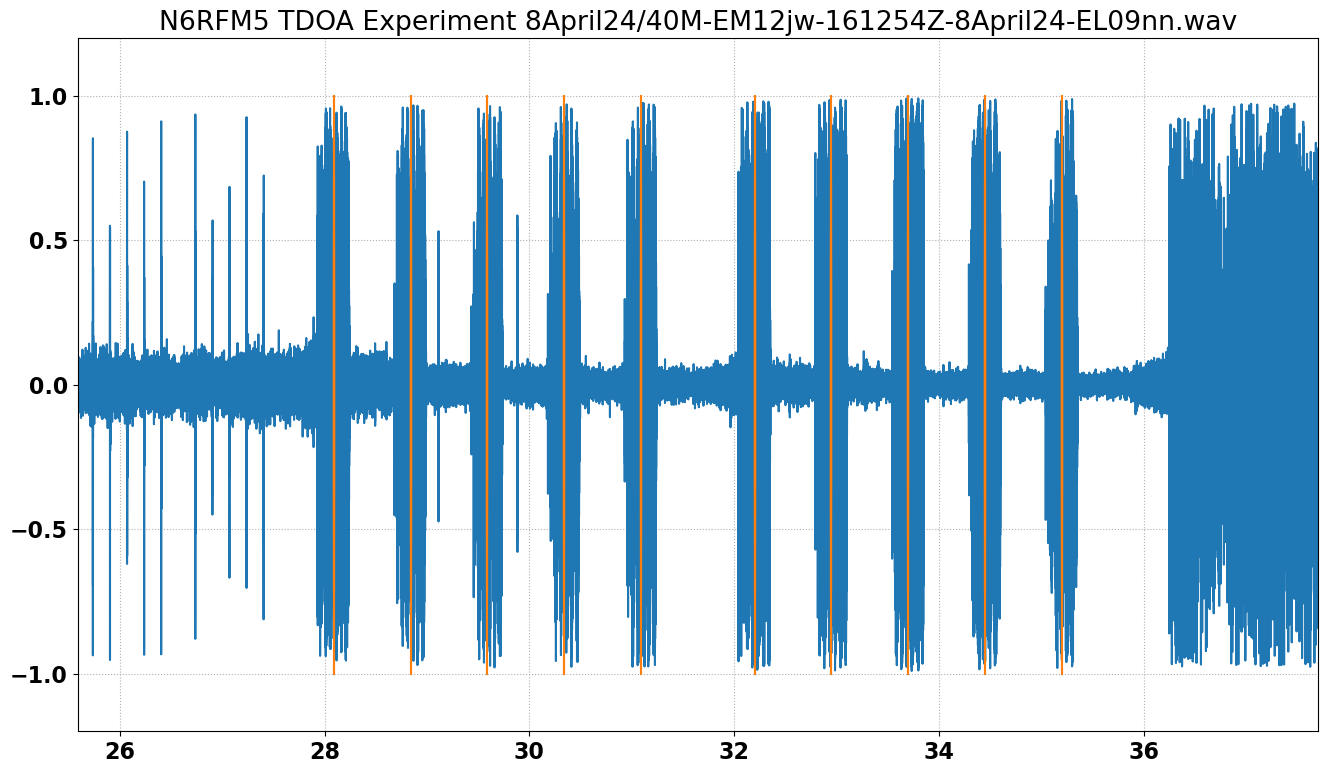

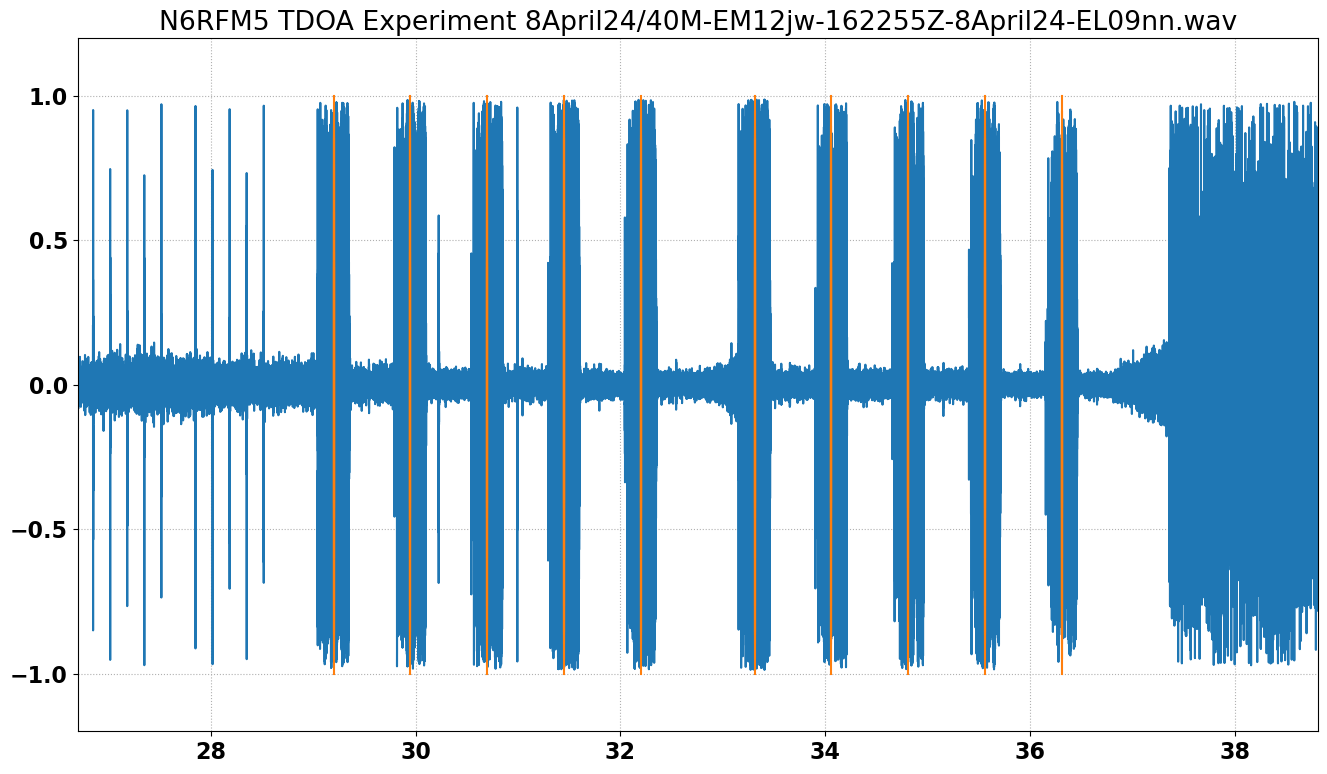

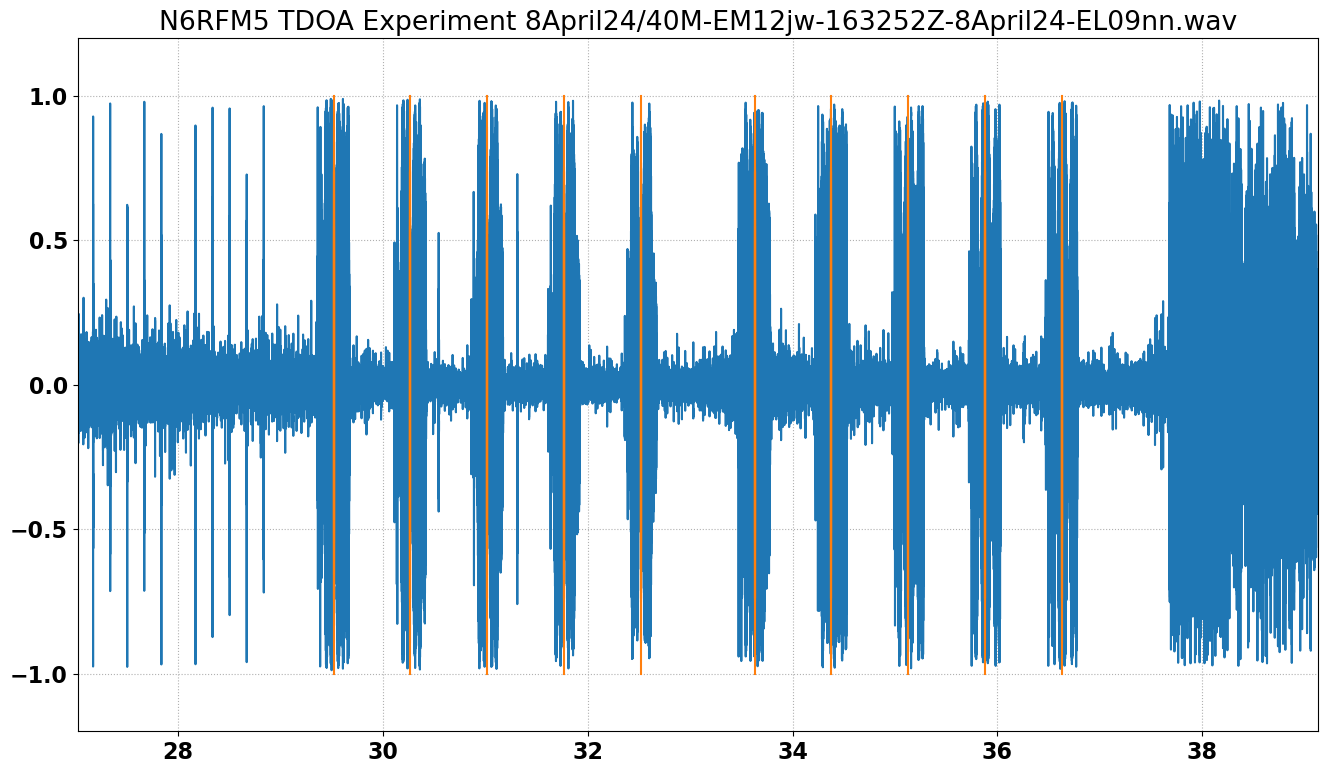

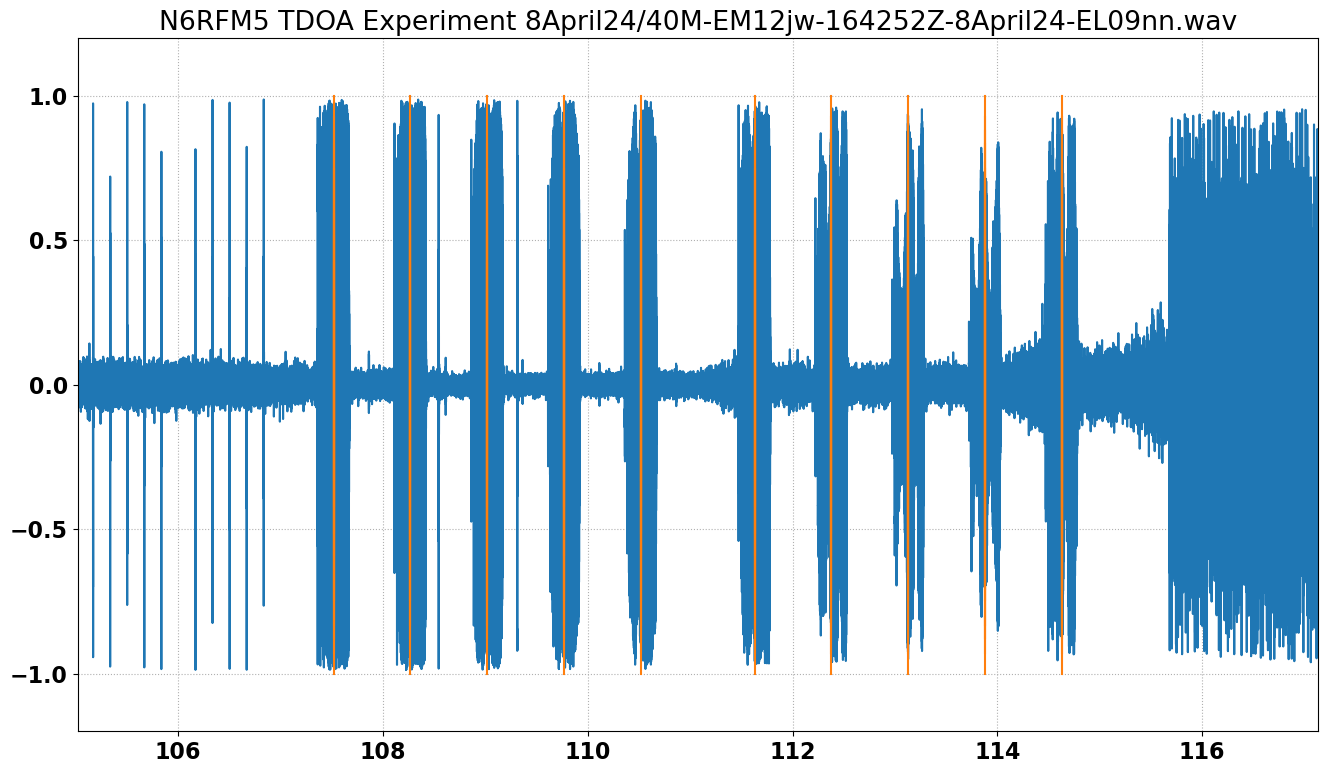

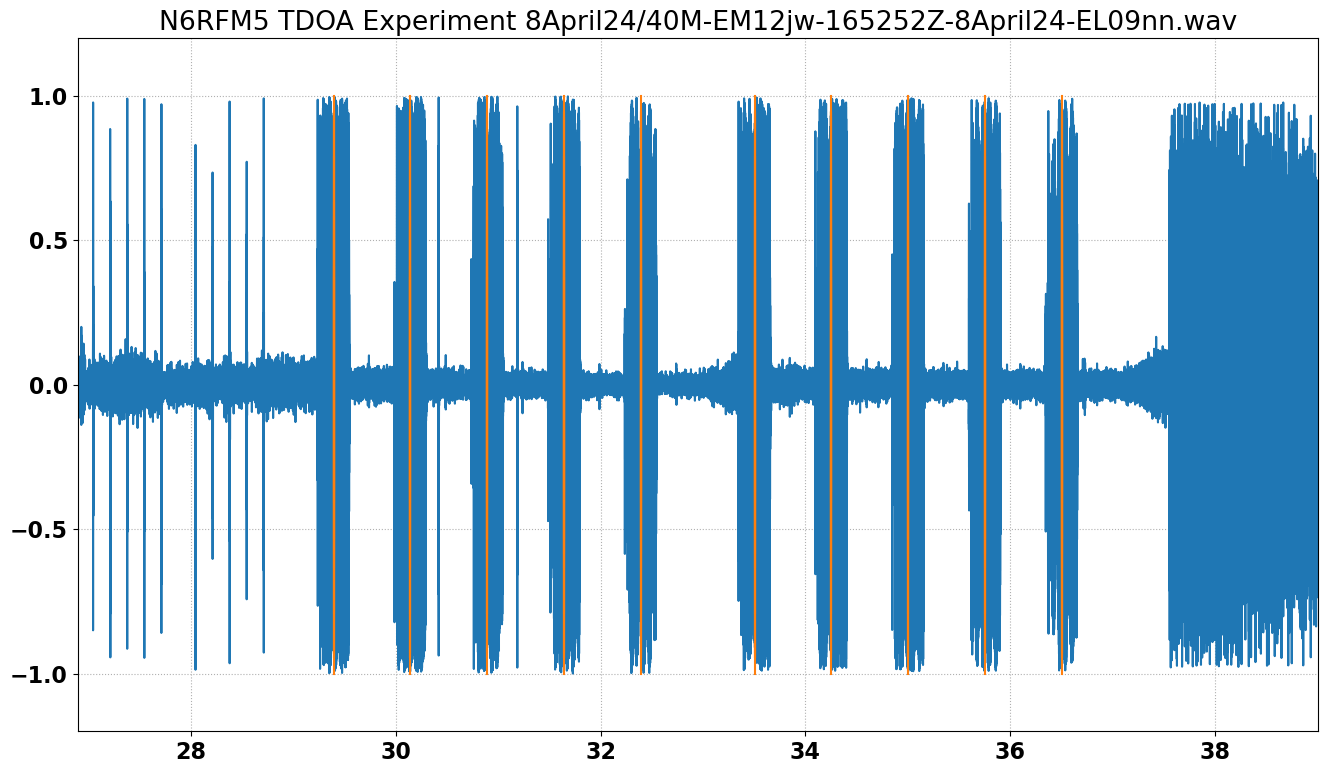

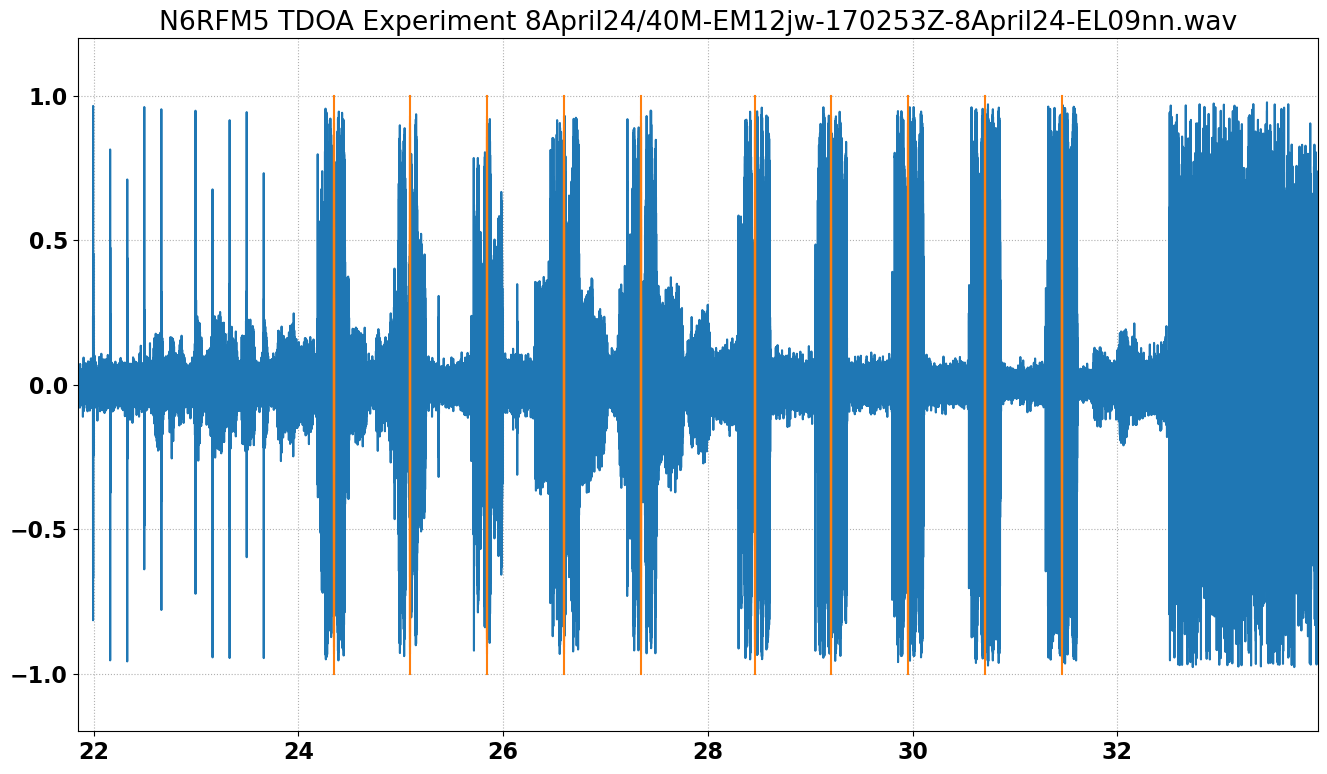

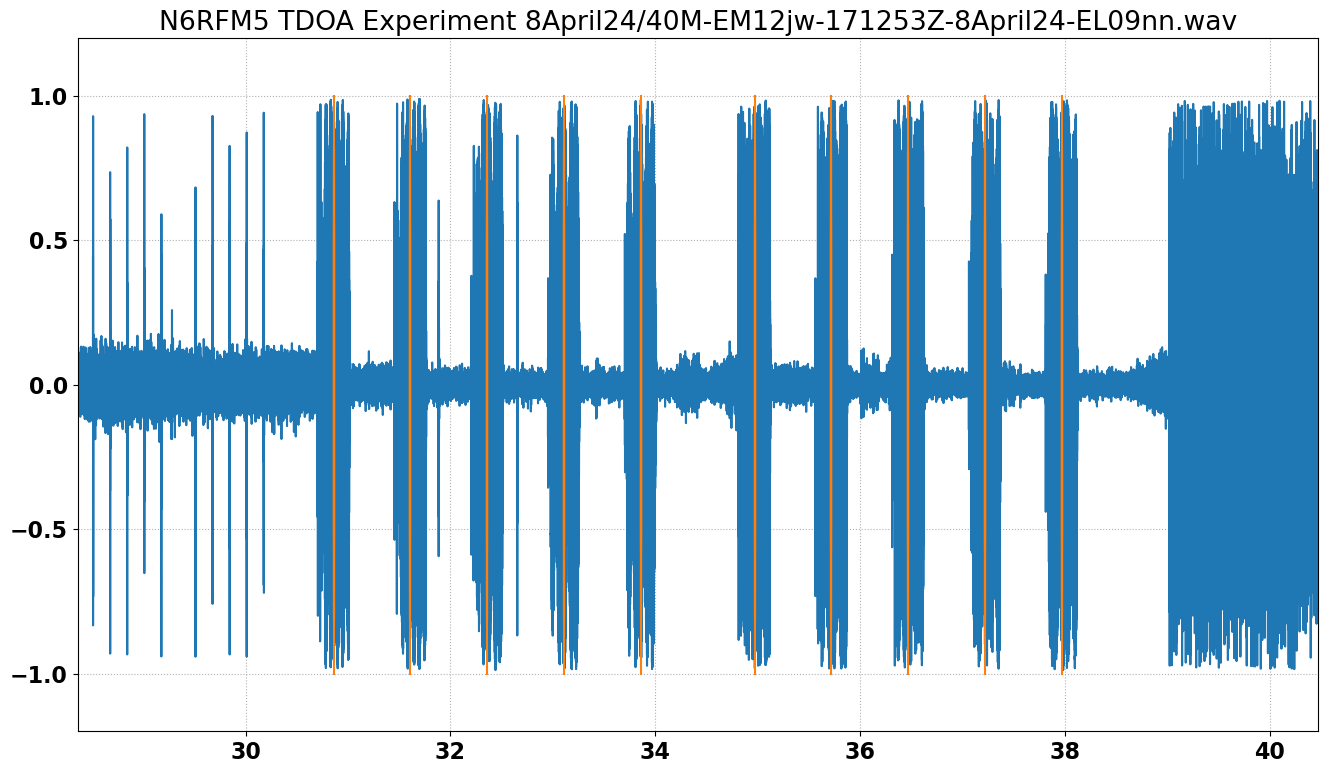

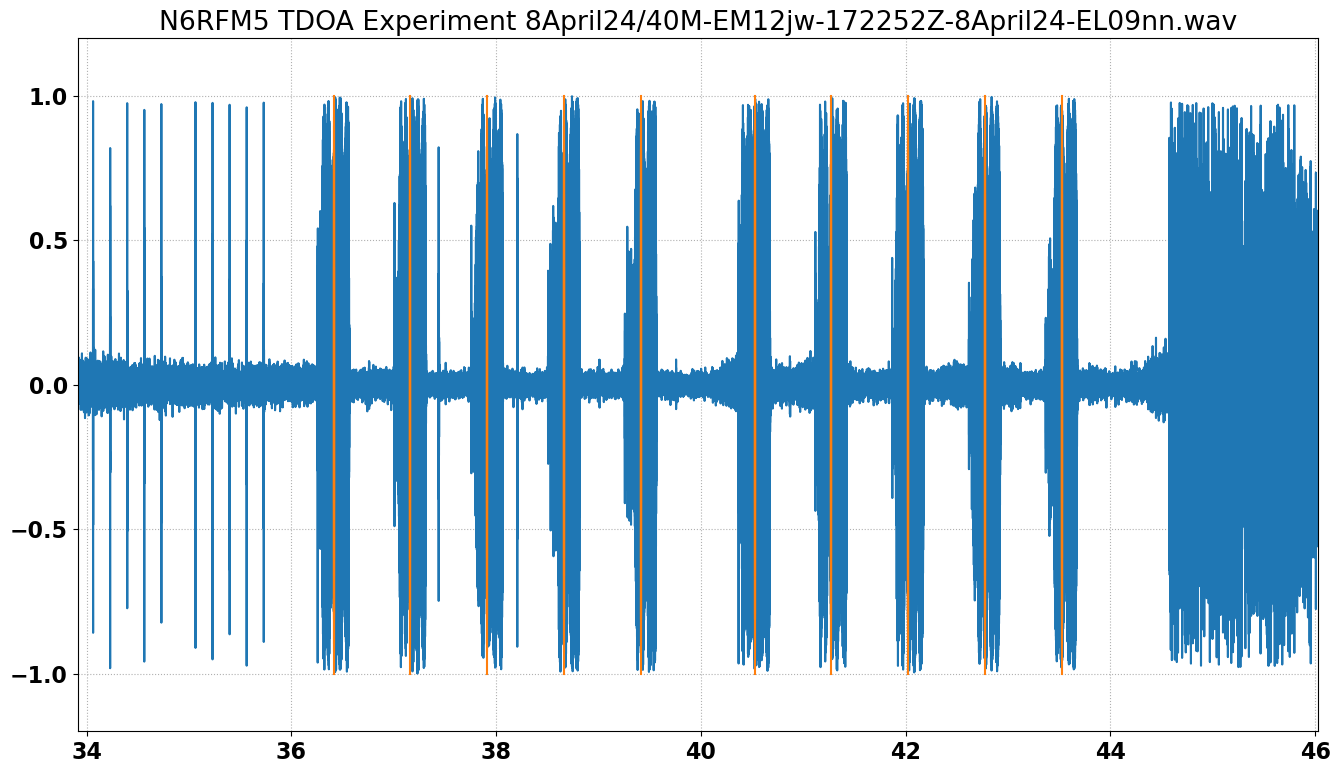

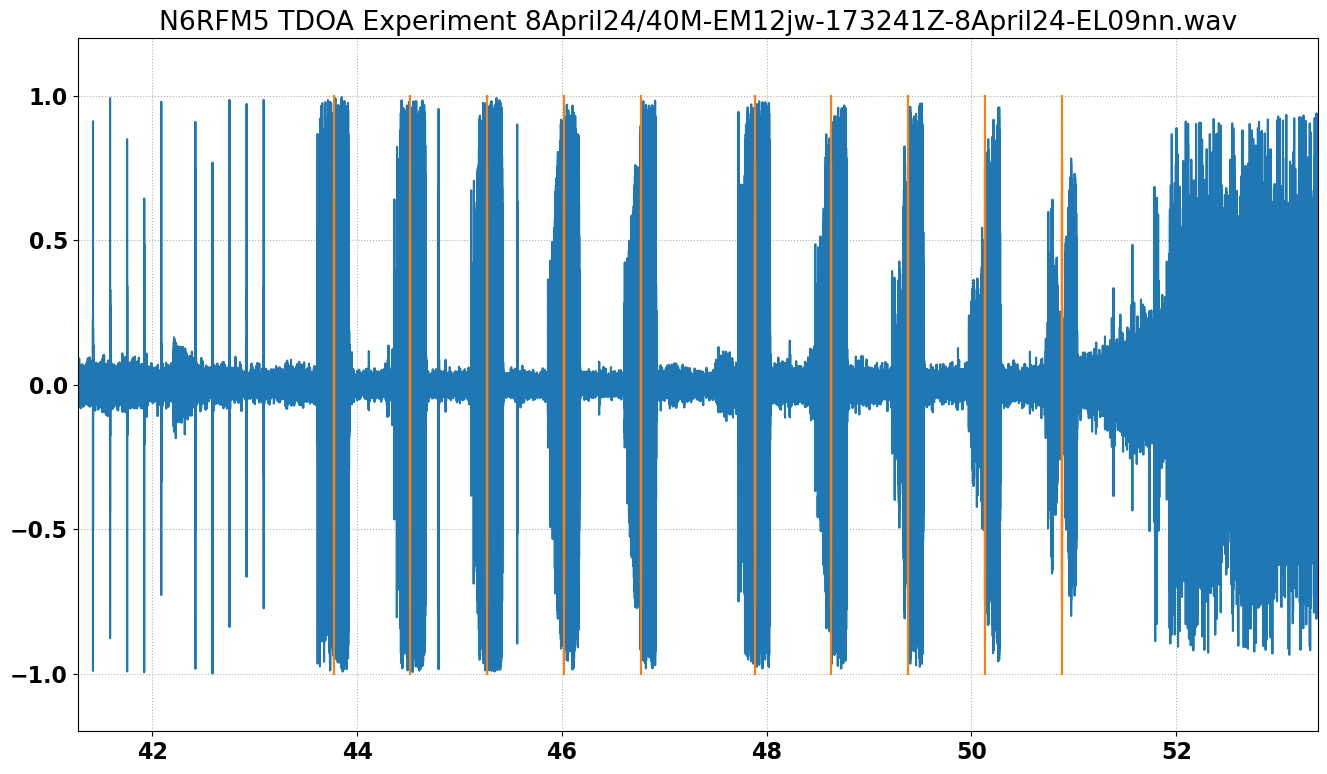

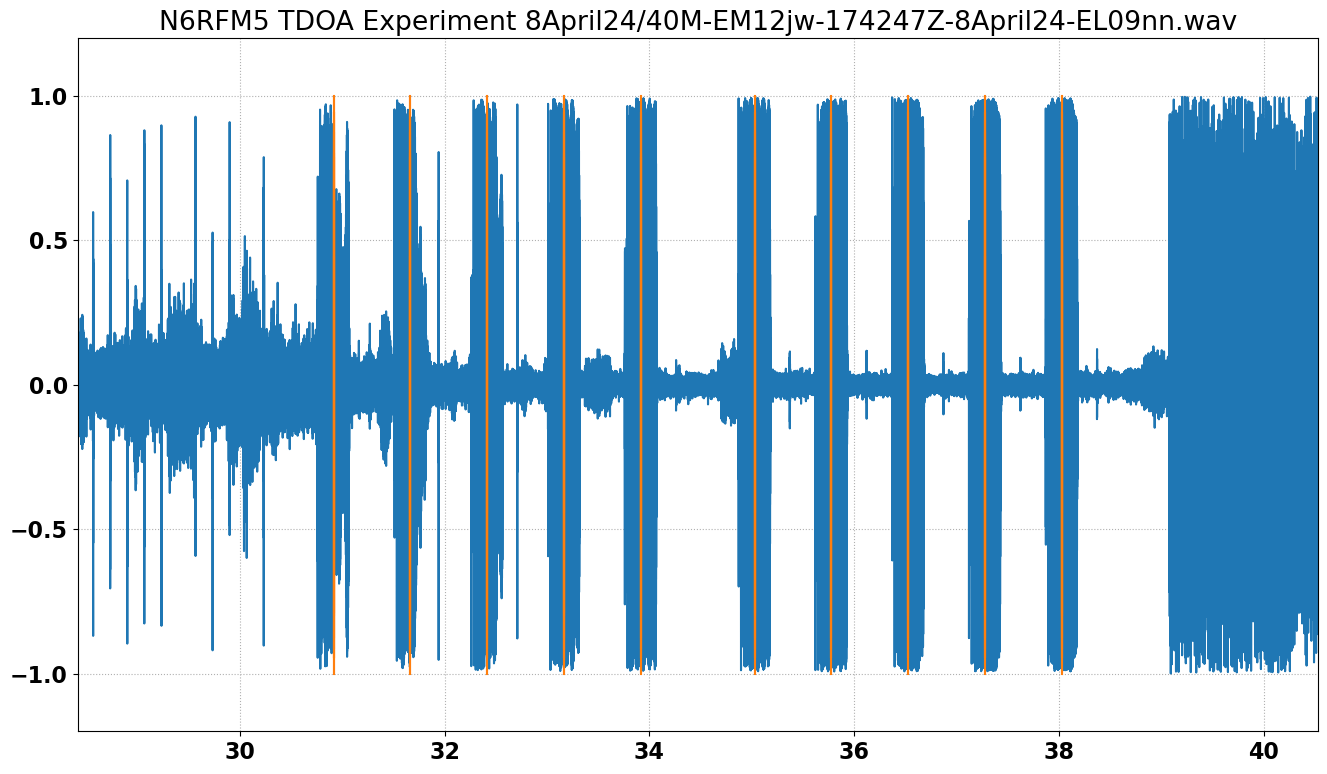

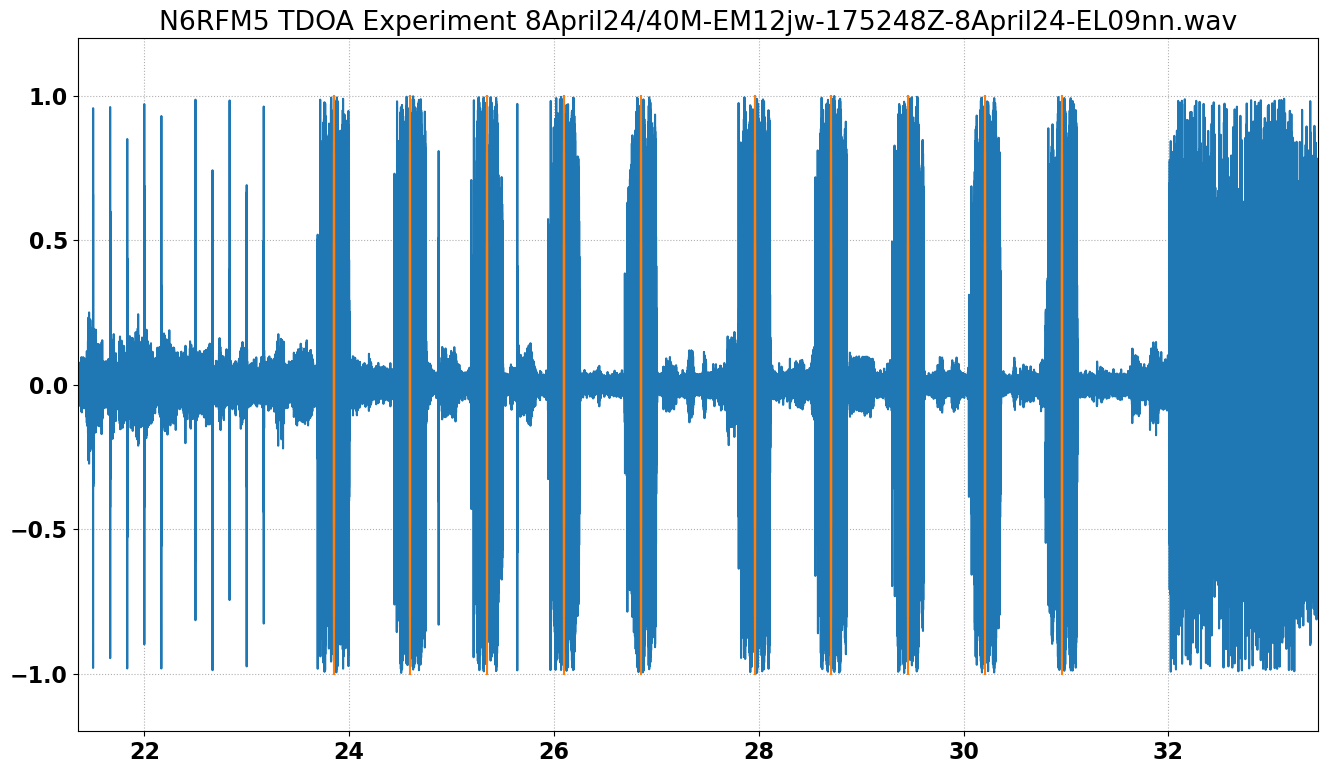

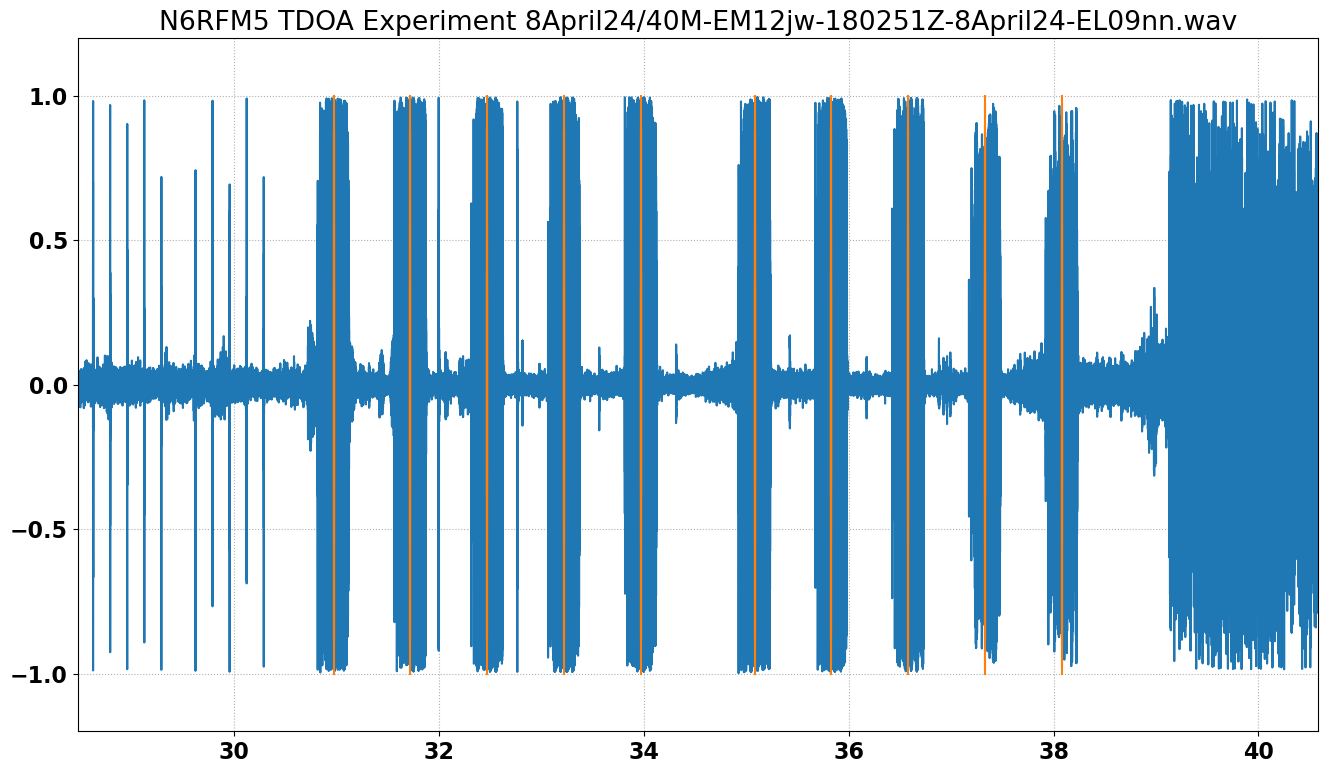

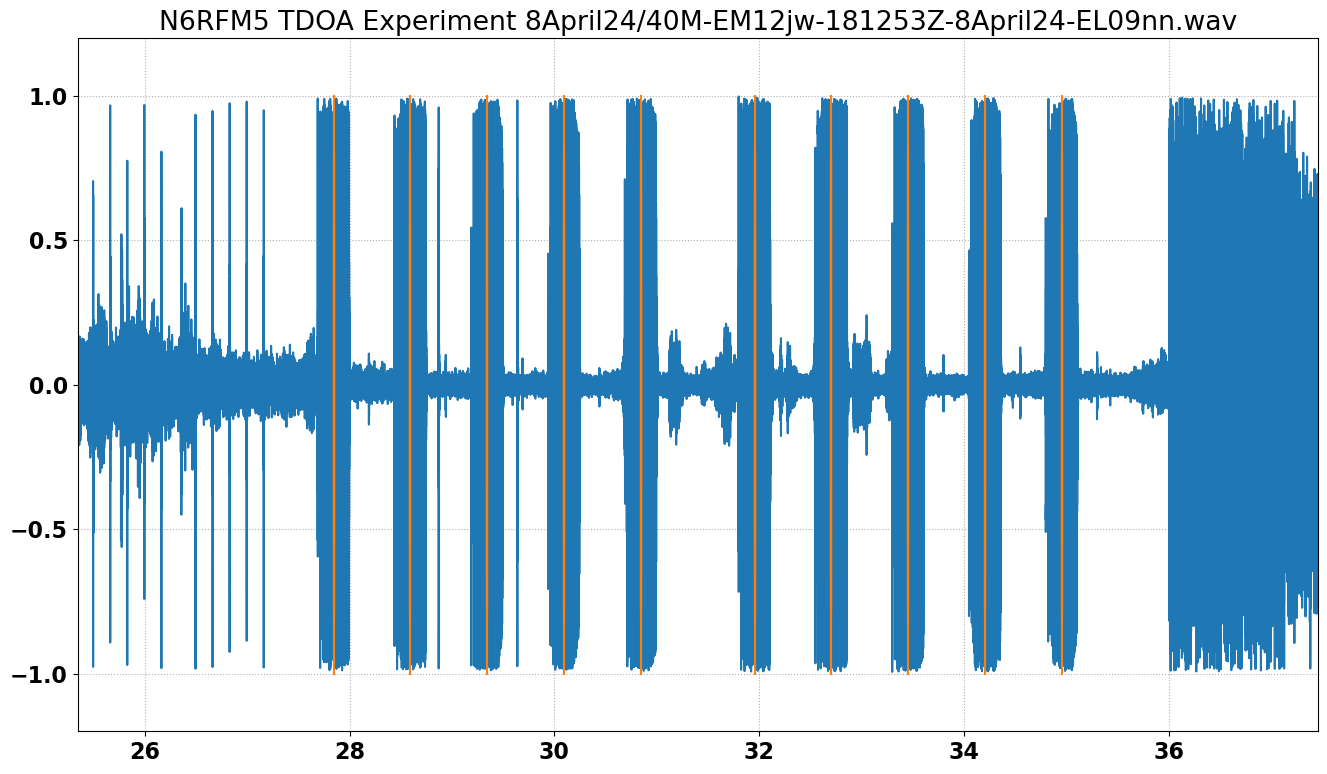

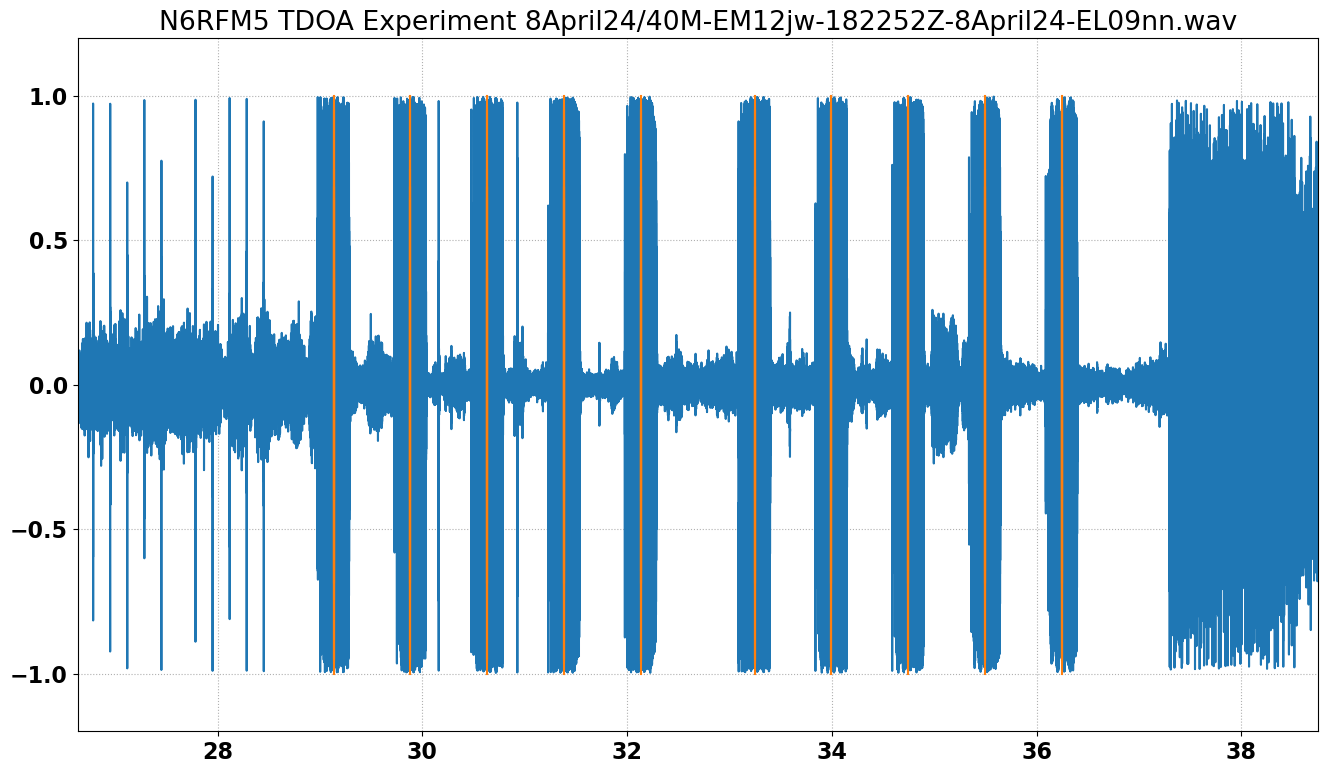

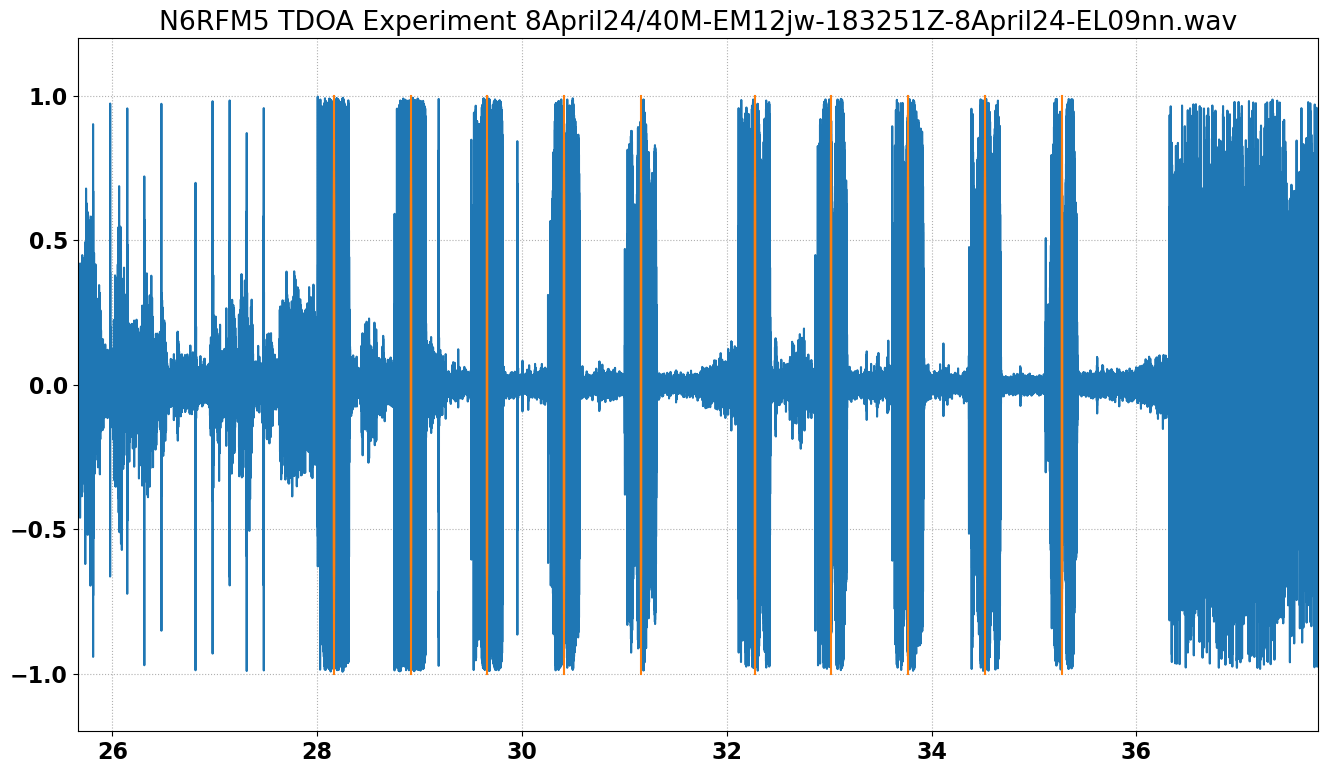

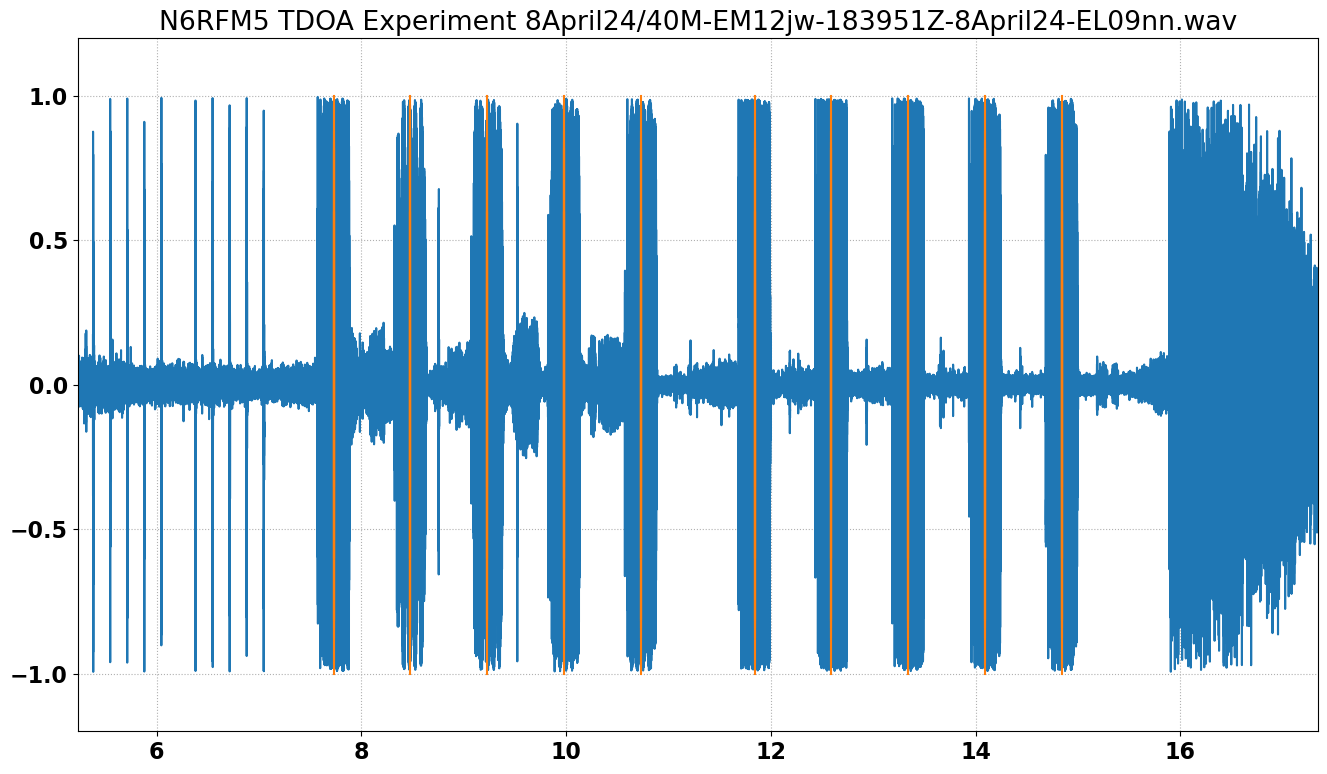

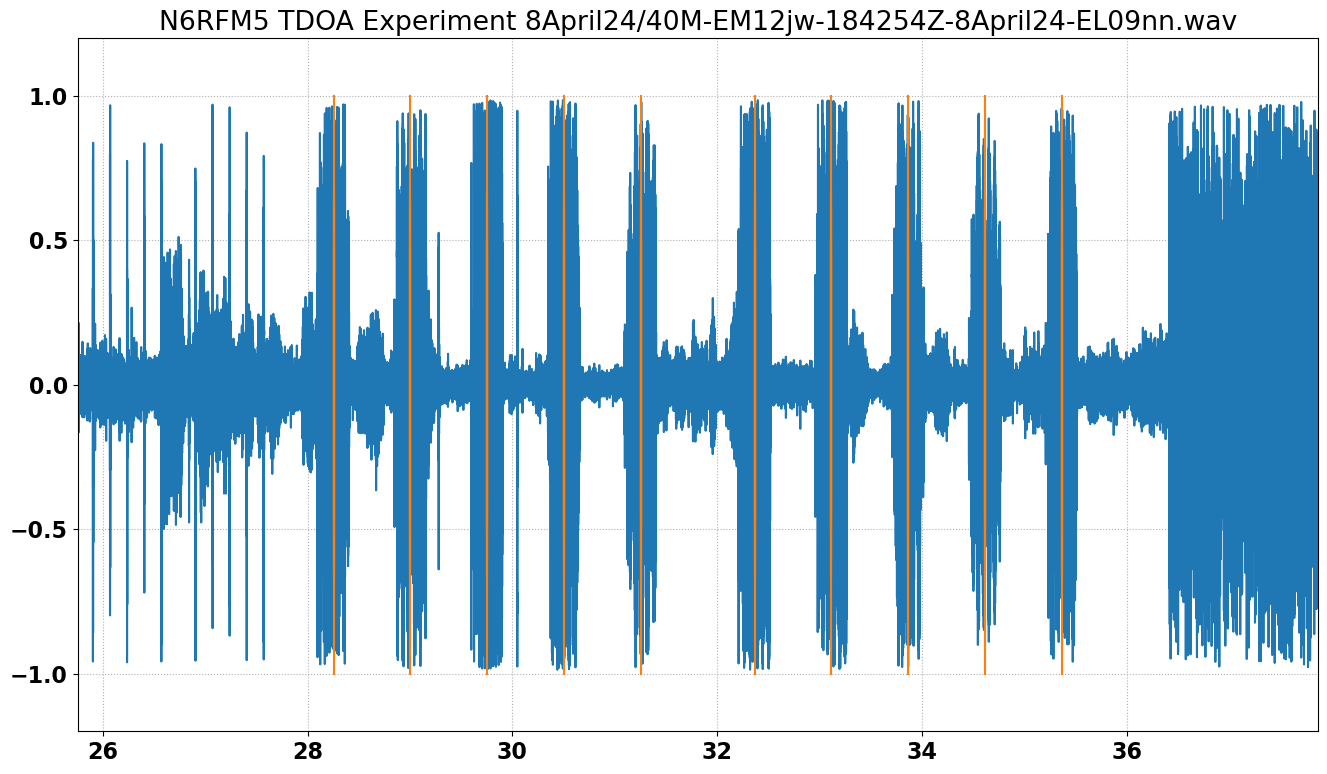

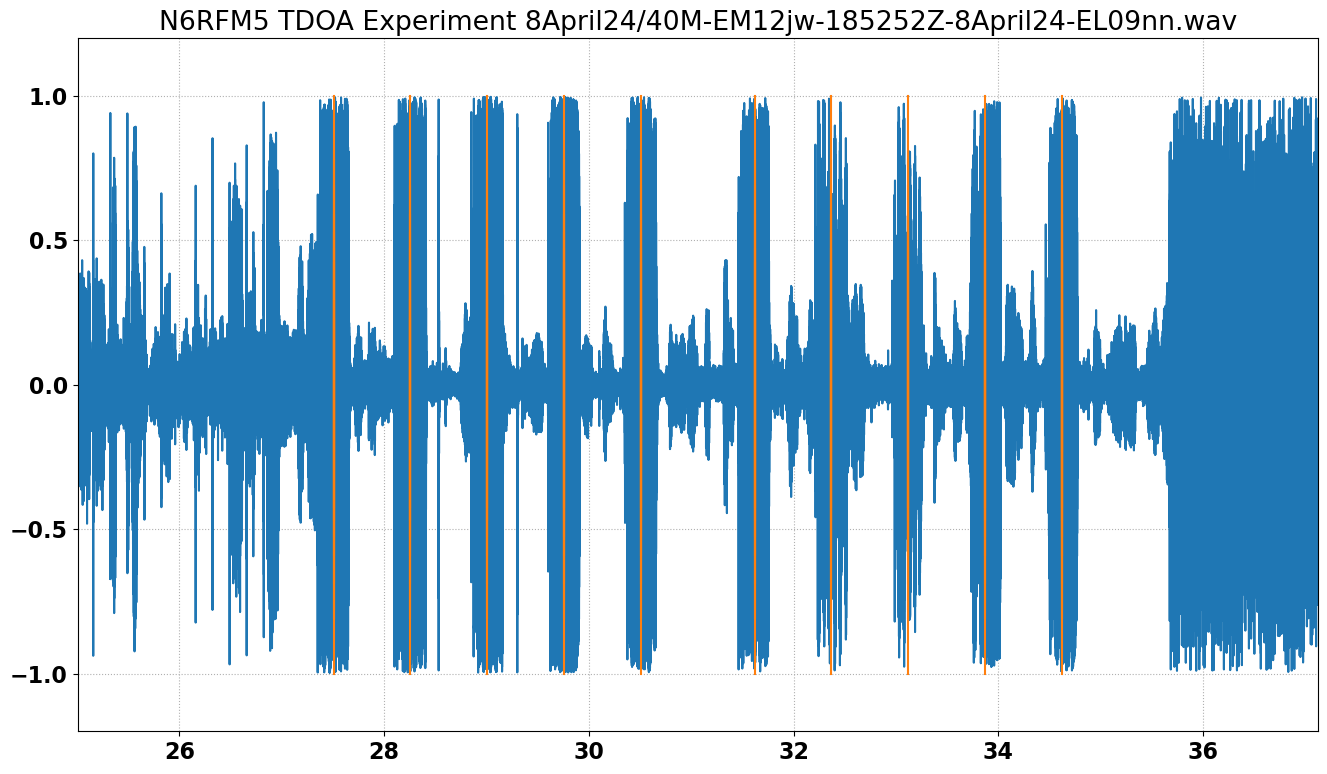

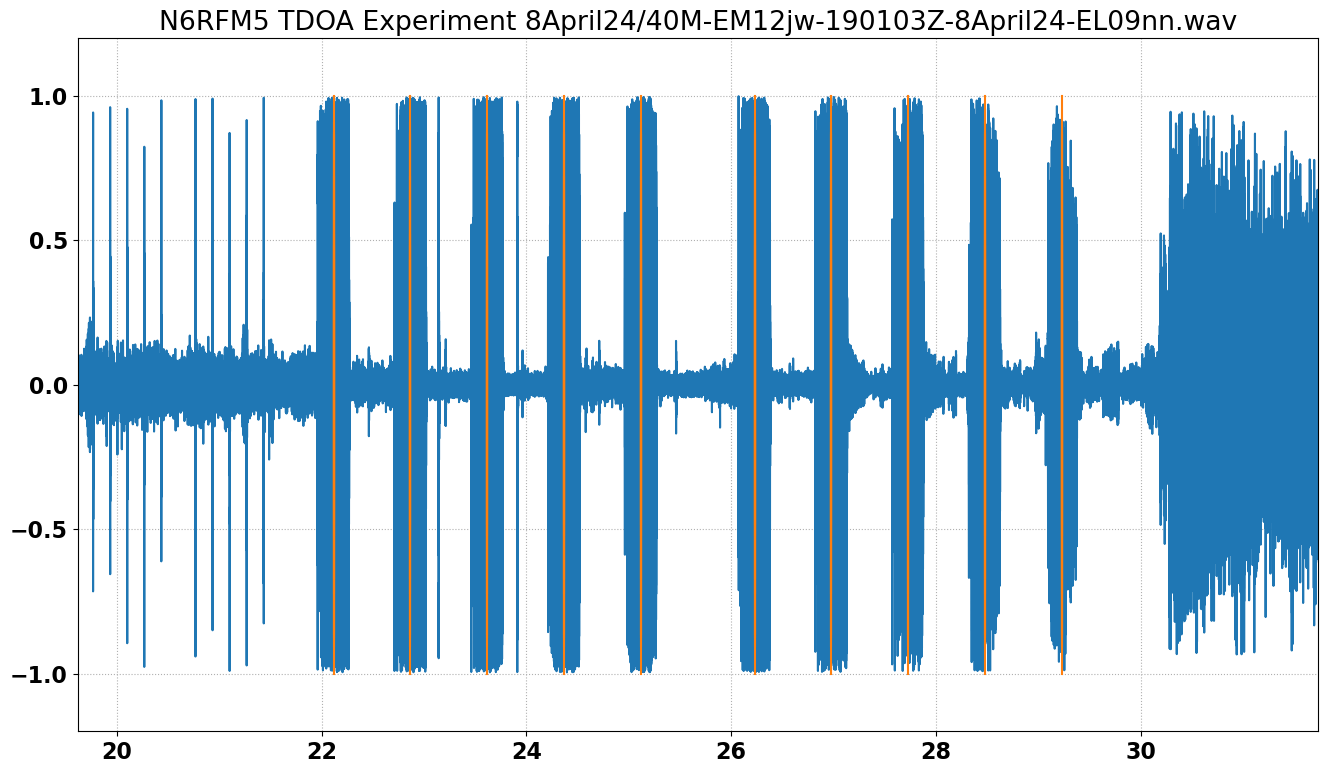

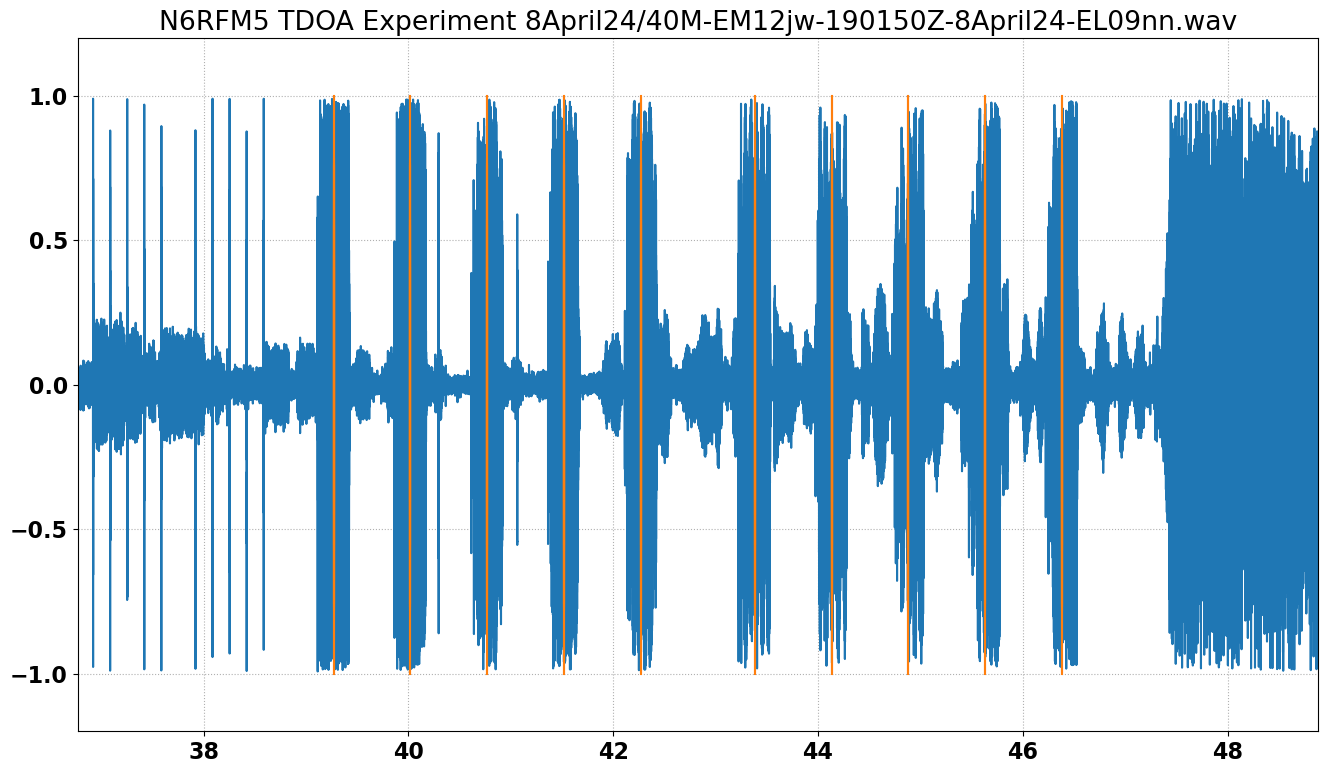

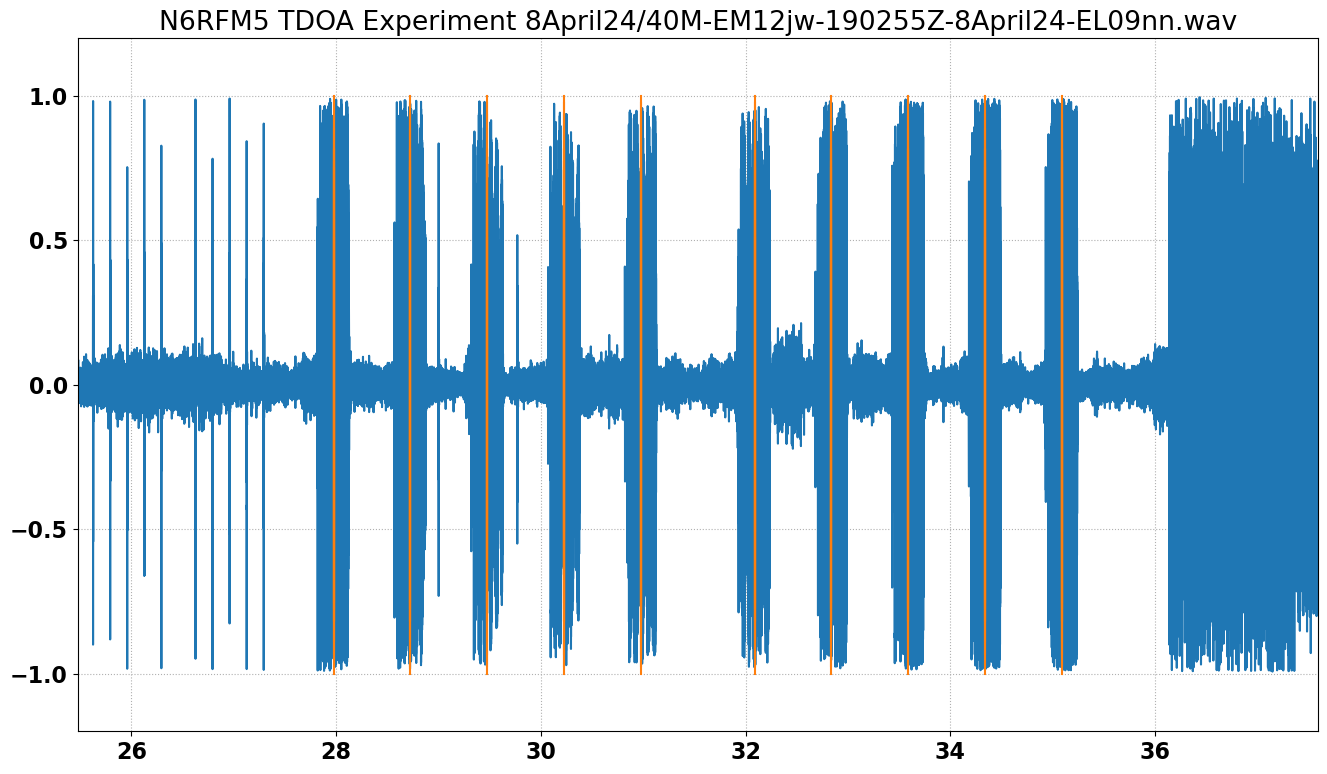

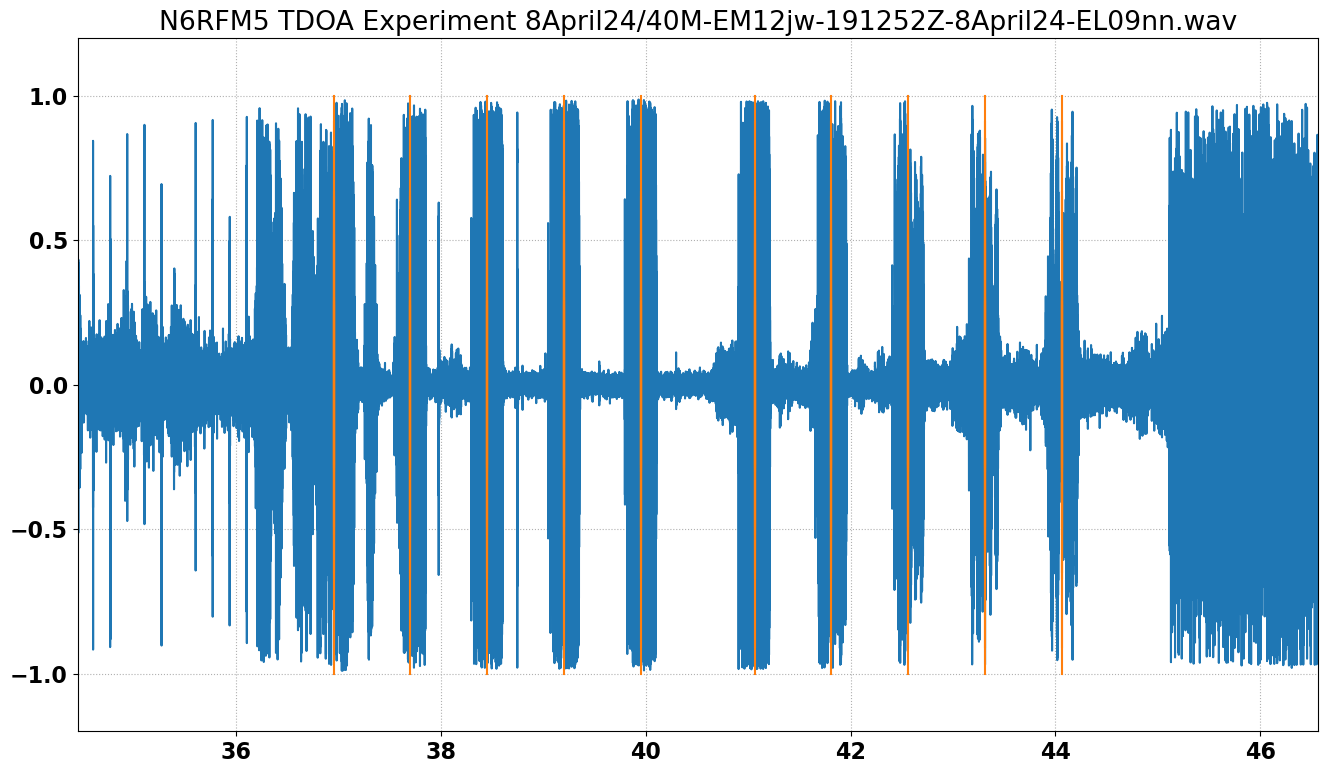

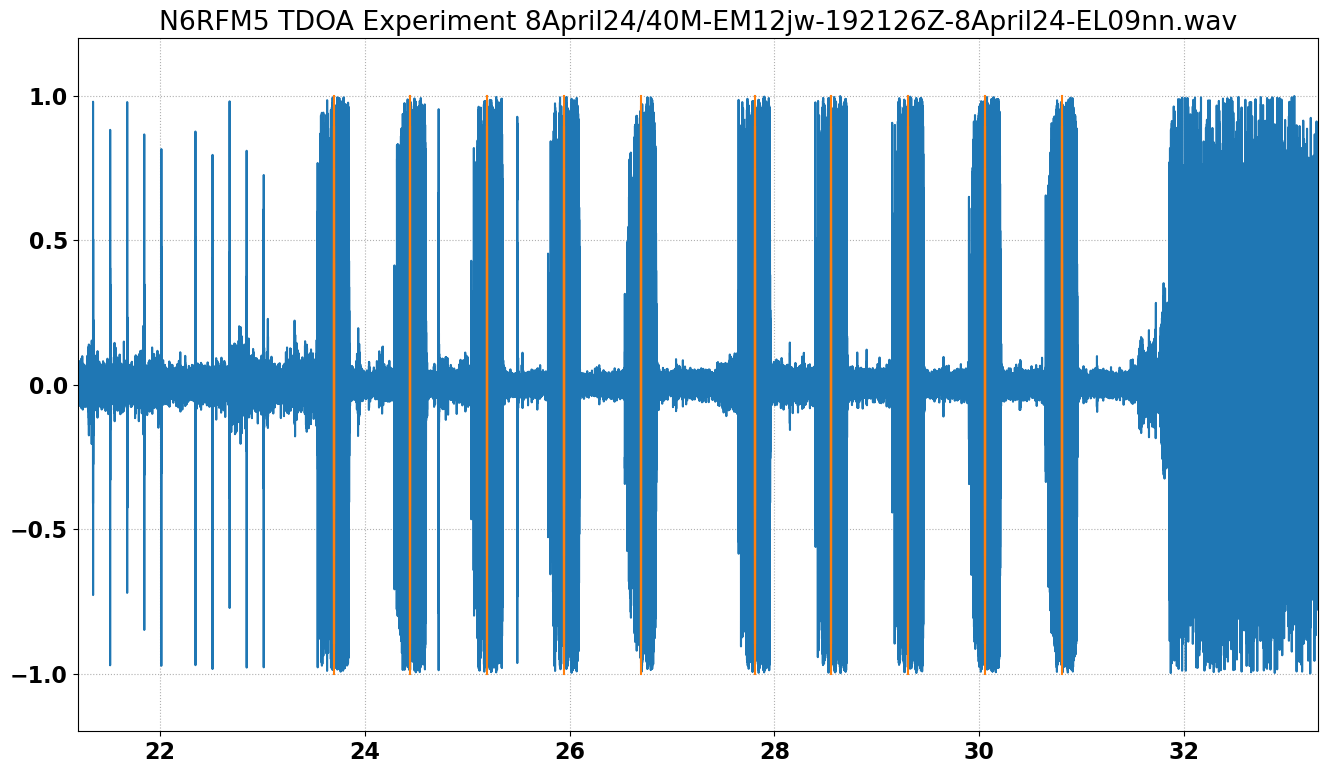

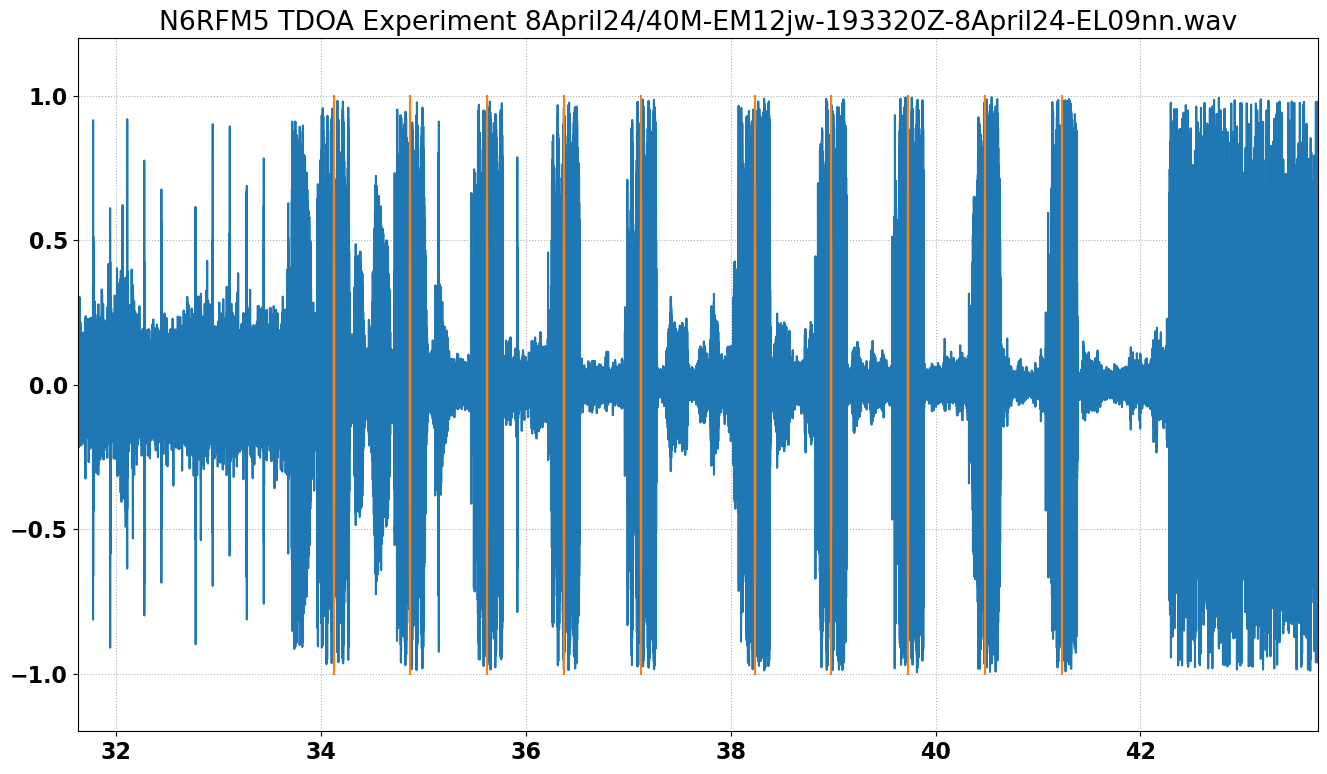

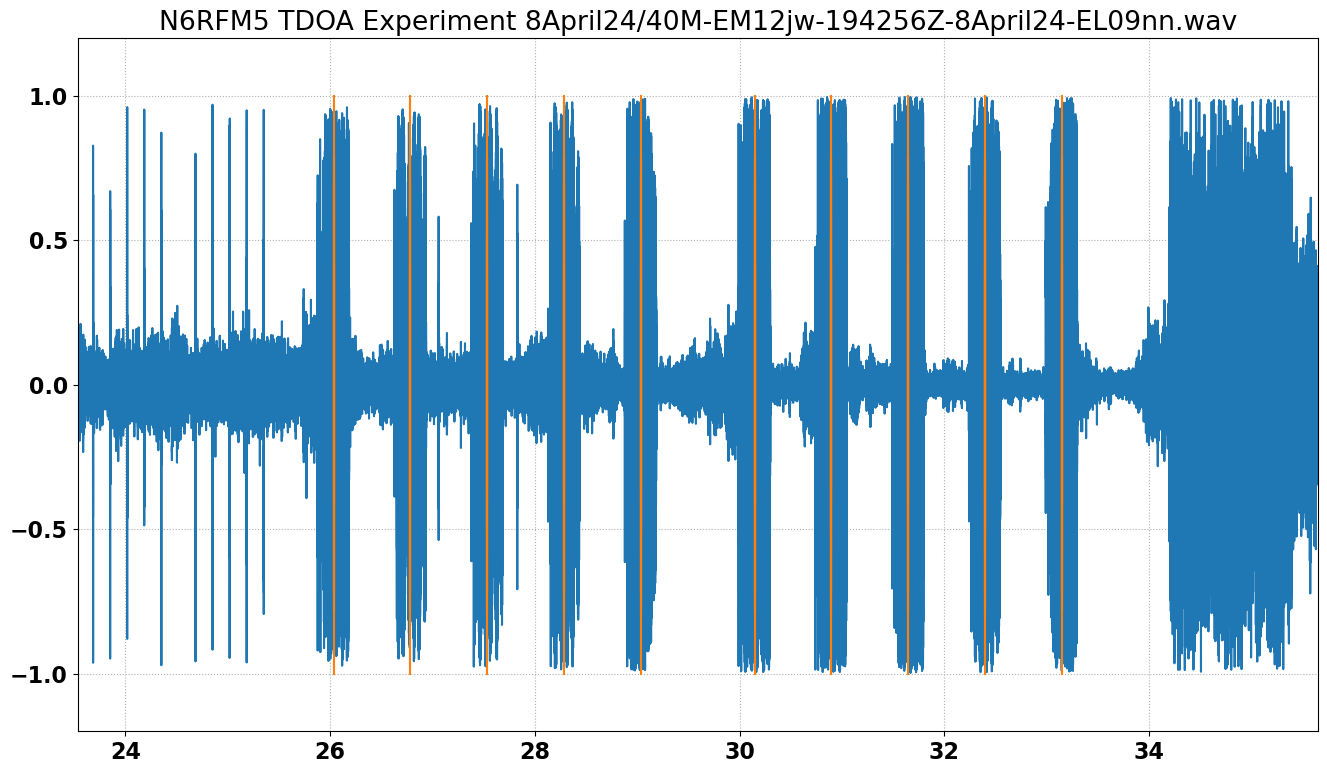

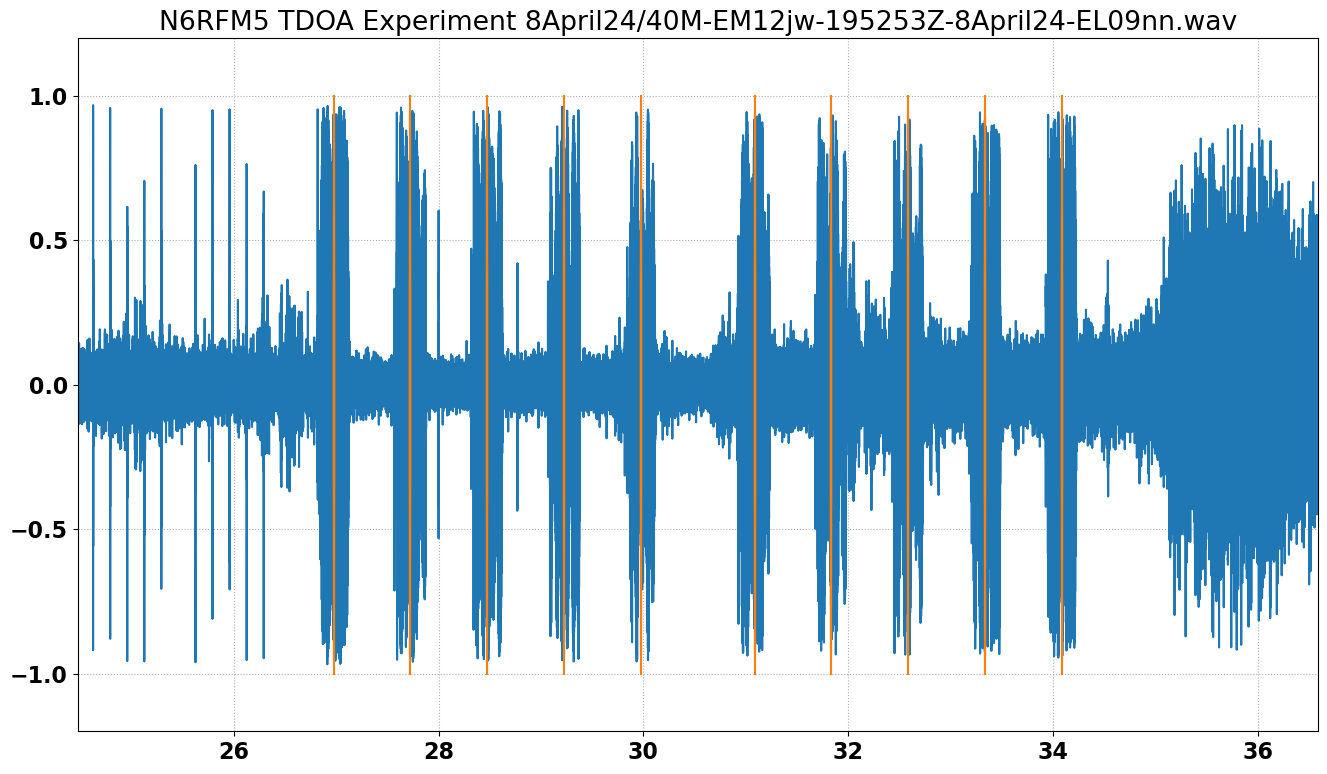

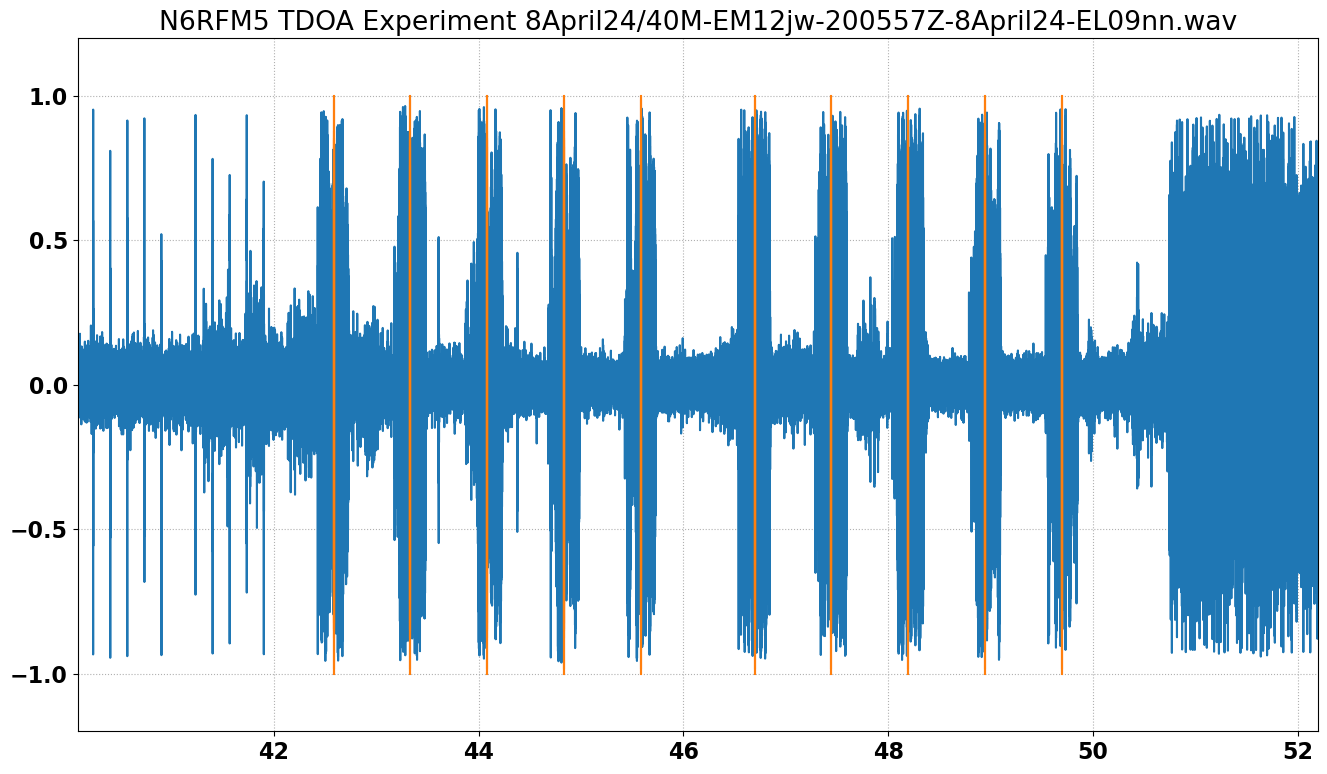

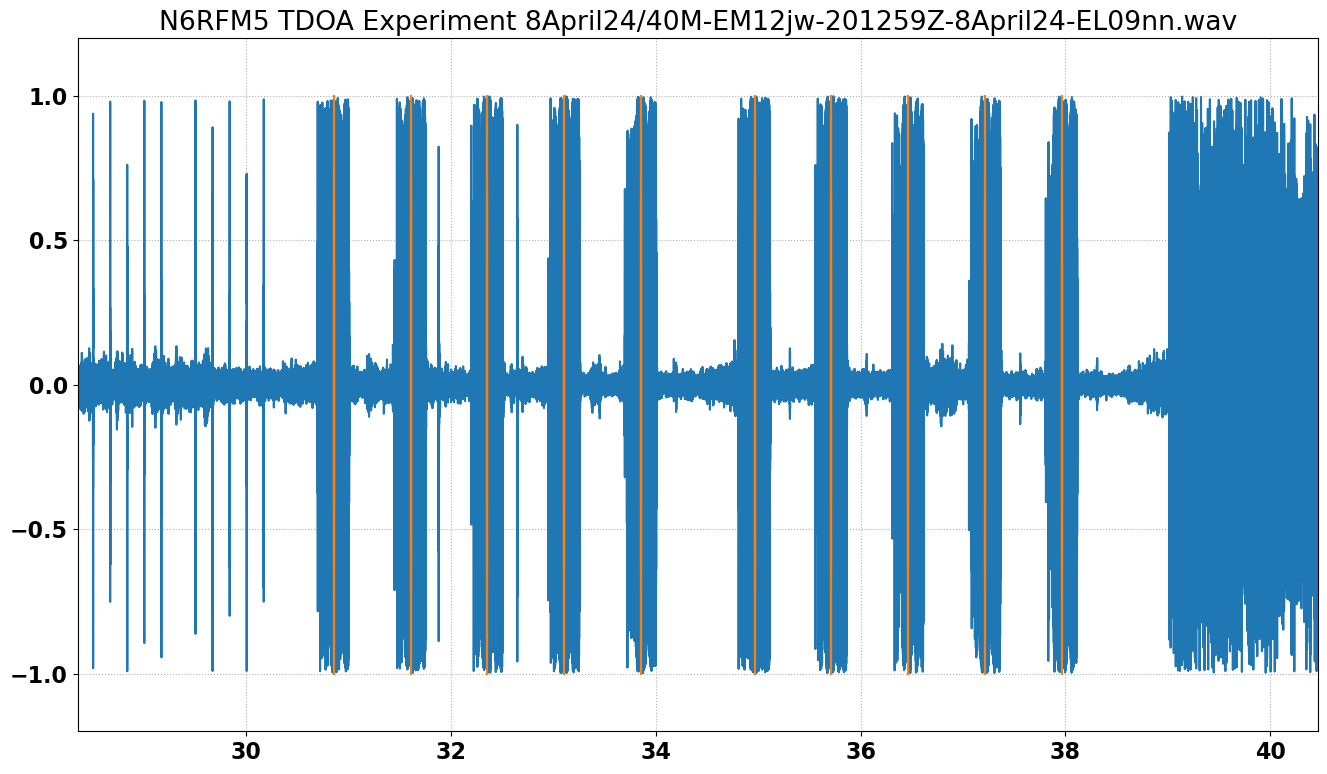

In [12]:
# Path to samples
sample_directory = 'testing/'
N6_sample = sample_directory+'n6-10Hztestsample.wav'
KD_sample = sample_directory+'20chirp.wav'
N540_sample = sample_directory + '40N5chirp.wav'
N560_sample = sample_directory + '60N5chirp.wav'
AB40_sample = sample_directory + '40ABchirp.wav'
AB60_sample = sample_directory + '60ABchirp.wav'
W3USR_sample = sample_directory + 'W3USR_chirp.wav'


# Correlation
#W3USR_chirps = find_chirps(wavlist_scranton, W3USR_sample, False)
N6_Chirps = find_chirps(wavlist_40mN6RFM5,N6_sample,True)
# KD_Chirps = find_chirps(wavlist_20m,KD_sample,False)
#N540_Chirps = find_chirps(wavlist_40m, N540_sample, False)     
# N560_Chirps = find_chirps(wavlist_60m, N560_sample, False)
# AB40_Chirps = find_chirps(wavlist_40mSam, AB40_sample, False)
# AB60_Chirps = find_chirps(wavlist_60mSam, AB60_sample, False)

In [13]:
# filter limits are done for the high/low pass portion
filter_limts = [10,50]
N6_limits = [-.1,.1,11,20] #7
N6_TDOAs_F = find_TDOAs(N6_Chirps,N6_limits,filter_limts,False)

filter_limts = [2.5,30]
N6_limits = [-.1,.1,5,12]
N6_TDOAs_E = find_TDOAs(N6_Chirps,N6_limits,filter_limts,False)

filter_limts = [20, 30]
N6_limits_ = [-.1,.1,22,30]
N6_TDOAs_ = find_TDOAs(N6_Chirps,N6_limits_,filter_limts,False)

# filter_limts = [5,60]
# KD_limits = [-.15,.15,10,30]
# KD_TDOAs_F = find_TDOAs(KD_Chirps,KD_limits,filter_limts,False)

# filter_limts = [0,30]S
# KD_limits = [-.15,.15,5,11]
# KD_TDOAs_E = find_TDOAs(KD_Chirps,KD_limits,filter_limts,False)

# filter_limts = [10,50]
# N5DUP60_limits = [-.1,.1,11,20] #7
# N5DUP_TDOAs_F = find_TDOAs(N560_Chirps,N5DUP60_limits,filter_limts,False)

# filter_limts = [2.5,30]
# N5DUP60_limits = [-.1,.1,5, 12] #7
# N5DUP_TDOAs_E = find_TDOAs(N560_Chirps,N5DUP60_limits,filter_limts,False)
# filter_limts = [20,30]
# N5DUP60_limits = [-.1,.1,22, 30] #7
# N5DUP_TDOAs_ = find_TDOAs(N560_Chirps,N5DUP60_limits,filter_limts,False)

# filter_limts = [10,50]
# N5DUP40_limits = [-.1,.1,11,20] #7
# N5DUP40_TDOAs_F = find_TDOAs(N540_Chirps,N5DUP40_limits,filter_limts,False)
# filter_limts = [2.5,30]
# N5DUP40_limits = [-.1,.1,5, 12] #7
# N5DUP40_TDOAs_E = find_TDOAs(N540_Chirps,N5DUP40_limits,filter_limts,False)
# filter_limts = [20,30]
# N5DUP40_limits = [-.1,.1,22, 30] #7
# N5DUP40_TDOAs_ = find_TDOAs(N540_Chirps,N5DUP40_limits,filter_limts,False)


#W3usr E region
# filter_limts = [5, 60]
# W3USR_limits = [-.15,.15,4,10]
# W3USR_TDOAs_F = find_TDOAs(W3USR_chirps,W3USR_limits,filter_limts,True)

# #W3usr F region
# filter_limts = [0,30]
# W3USR_limits = [-.15,.15,6,16]
# W3USR_TDOAs_3F_2F = find_TDOAs(W3USR_chirps, W3USR_limits, filter_limts, False)

######################Test
# filter_limts = [10,50]
# AB40_limits = [-.1,.1,25,50]
# AB40_TDOAS_X = find_TDOAs(AB40_Chirps, AB40_limits,filter_limts, False)

# filter_limts = [10,50]
# AB40_limits = [-.1,.1,11,20]
# AB40_TDOAS_F = find_TDOAs(AB40_Chirps, AB40_limits,filter_limts, False)

# filter_limts = [10,50]
# AB40_limits = [-.1,.1,11,20]
# AB40_TDOAS_F = find_TDOAs(AB40_Chirps, AB40_limits,filter_limts, False)
# filter_limts = [2.5,30]
# AB40_limits = [-.1,.1,5,12]
# AB40_TDOAS_E = find_TDOAs(AB40_Chirps, AB40_limits,filter_limts, False)
# filter_limts = [20,30]
# AB40_limits = [-.1,.1,22,30]
# AB40_TDOAS_ = find_TDOAs(AB40_Chirps, AB40_limits,filter_limts, False)


In [14]:
def assign_times(directory, start_char_ind, end_char_ind):
    band_indices = []
    band_times = []
    hour = 0
    minute = 0
    
    for i, file in enumerate(os.listdir(directory)):
        band = file[start_char_ind:end_char_ind]
        
        if band == 'EM02CH':
            hour = int(file[18:20])
            minute = int(file[20:22])
        elif band == 'EL09nn':
            hour = int(file[18:20])
            minute = int(file[20:22]) 
        elif band == '2024':
            if directory == '20M_TX-N5DUP_RX-W3USR_2236km':
                hour = int(file[9:11])
                minute = int(file[11:13])
            elif directory == 'AG5HR':
                hour = int(file[9:11])
                minute = int(file[11:13])
        elif band == '2404':
            hour = int(file[7:9])
            minute = int(file[9:11])
        elif band == 'EM12':
            hour = int(file[11:13])
            minute = int(file[13:15])
        
        band_indices.append(i)
        band_times.append(datetime.datetime(year, month, day, hour, minute))
    
    return band_indices, band_times

In [15]:
year = 2024
month = 4
day = 8

In [16]:
N6RFM5band, N6RFM5band_times = assign_times(directory_40mN6RFM5, 4, 8)
# N5DUP60band, N5DUP60band_times = assign_times(directory_60m, 4, 10)
#N5DUP40band, N5DUP40band_times = assign_times(directory_40m, 4, 10)
#AB40band, AB40band_times = assign_times(directory_40mSam, 0, 4)
# W3USRband, W3USRband_times = assign_times(directory_scranton, 0, 4)
# print(N6RFM5band, N6RFM5band_times)
# print(N5DUP40band, N5DUP40band_times)
# print(N5DUP60band, N5DUP60band_times)
# print(N5DUP_TDOAs_F)
# print(N5DUP_TDOAs_E)
# print(N5DUP_TDOAs_)
# print(W3USRband, W3USRband_times)

In [16]:
# def plot_hmf2(TDOAs,set_name,times, plotTDOAS = False):
    
#     times = np.array(times)
#     TDOAs = np.nanmean(TDOAs, axis = 1)
    
#     print(len(times))
#     print(len(TDOAs))
    
#     if plotTDOAS == True:
#         fig = plt.figure(figsize=(16,9))
#         ax = fig.add_subplot(1,1,1)
#         ax.scatter(times,TDOAs,label = 10)
#         ax.plot(times,TDOAs)
    
    
    
#     # ax.plot(np.mean(TDOAs,axis=1))
#     if set_name == '1F2-2F2':
#         ax2 = ax.twinx()
#         miny = 1
#         maxy = 2.5
#         ax2.yaxis.set_ticks_position("right")
#         ax2.yaxis.set_label_position("right")
#         ax2.set_frame_on(True)
#         ax2.patch.set_visible(False)
#         layer_heights = np.arange(miny, maxy + 0.1, 0.25)
#         ax2.set_yticks(np.arange(0,len(layer_heights)))
#         ax2.set_yticklabels((140.2 * layer_heights) + 48.3)
#         ax2.ticklabel_format()
#         ax2.set_ylabel('Layer Height [km]')
        
#     elif set_name == '1F2-1E':
#         ax2 = ax.twinx()
#         miny = 0.5
#         maxy = 1.5
#         ax2.yaxis.set_ticks_position("right")
#         ax2.yaxis.set_label_position("right")
#         ax2.set_frame_on(True)
#         ax2.patch.set_visible(False)
#         layer_heights = np.arange(miny, maxy + 0.1, 0.25)
#         ax2.set_yticks(np.arange(0,len(layer_heights)))
#         ax2.set_yticklabels((181.8 * layer_heights) + 135.5)
#         ax2.ticklabel_format()
#         ax2.set_ylabel('Layer Height [km]')
        
#     elif set_name == '2F2-1E':
#         ax2 = ax.twinx()
#         miny = 2
#         maxy = 3
#         ax2.yaxis.set_ticks_position("right")
#         ax2.yaxis.set_label_position("right")
#         ax2.set_frame_on(True)
#         ax2.patch.set_visible(False)
#         layer_heights = np.arange(miny, maxy + 0.1, 0.25)
#         ax2.set_yticks(np.arange(0,len(layer_heights)))
#         ax2.set_yticklabels((79.4 * layer_heights) + 85.6)
#         ax2.ticklabel_format()
#         ax2.set_ylabel('Layer Height [km]')

#     ax.set_ylim(miny,maxy)
    
    

#     import matplotlib.dates as mdates

#     myFmt = mdates.DateFormatter('%H:%M')
#     ax.xaxis.set_major_formatter(myFmt)
#     ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))

#     ax.set_ylabel('TDOA [ms]')
#     ax.set_xlabel('time')
#     ax.legend()
#     ax.set_title(set_name)
#     fig.autofmt_xdate()
#     plt.tight_layout()
#     plt.show()
#     plt.close(fig)

In [16]:
plot_hmf2(N6_TDOAs_F, set_name = '1F2-2F2', times = N6RFM5band_times)
plot_hmf2(N6_TDOAs_E,set_name= '1F2-1E', times = N6RFM5band_times)
plot_hmf2(N6_TDOAs_,set_name= '2F2-1E', times = N6RFM5band_times)

NameError: name 'plot_hmf2' is not defined

Strictly plots TDOAs as a function of Time in UTC

In [19]:
def plot_TDOAs(TDOAs_sets, set_names, times, plotTDOAS=False, grnd = None):
    times = np.array(times)
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(1, 1, 1)
    
    for TDOAs, set_name in zip(TDOAs_sets, set_names):
        TDOAs = np.nanmean(TDOAs, axis=1)
        if plotTDOAS:
            ax.scatter(times, TDOAs, label=set_name)
            ax.plot(times, TDOAs)
            print(len(TDOAs))
            print(len(times))
    
        miny = 0
        maxy = 3 #Originally 3
        ax.set_ylim(miny, maxy)
    
    import matplotlib.dates as mdates
    myFmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))

    ax.set_ylabel('TDOA [ms]')
    ax.set_xlabel('Time UTC')
    ax.legend()
    ax.set_title('TDOA Sets Tx: WA5FRF Rx: ' + grnd)
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()
    plt.close(fig)


40
40
40
40
40
40


C:\Users\alexp\AppData\Local\Temp\ipykernel_9148\1049126238.py:7: RuntimeWarning: Mean of empty slice
  TDOAs = np.nanmean(TDOAs, axis=1)


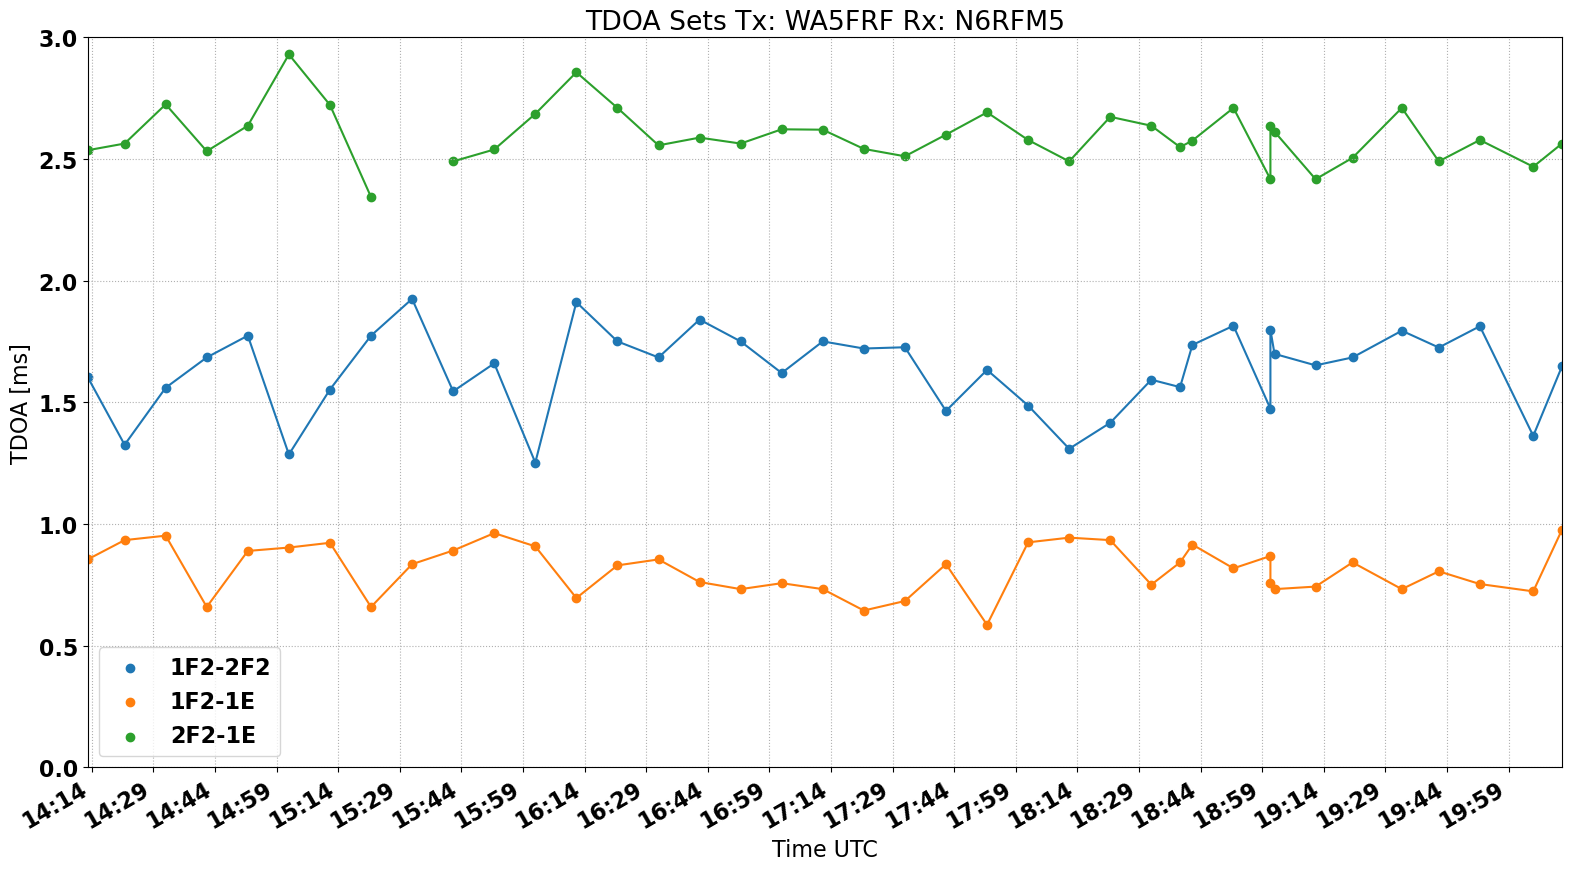

In [21]:
# plot_TDOAs(
#     TDOAs_sets=[N5DUP_TDOAs_F, N5DUP_TDOAs_E, N5DUP_TDOAs_],
#     set_names=['1F2-2F2', '1F2-1E', '2F2-1E'],
#     times=N5DUP60band_times,
#     plotTDOAS=True,
#     grnd='N5DUP'
# )
# plot_TDOAs(
#     TDOAs_sets = [W3USR_TDOAs_F, W3USR_TDOAs_3F_2F],
#     set_names = ['1F2-2F2', '3F2-2F2'],
#     times = W3USRband_times,
#     plotTDOAS=True,
#     grnd = 'W3USR'
# )
plot_TDOAs(
    TDOAs_sets=[N6_TDOAs_F, N6_TDOAs_E, N6_TDOAs_],
    set_names=['1F2-2F2', '1F2-1E', '2F2-1E'],
    times=N6RFM5band_times,
    plotTDOAS=True,
    grnd='N6RFM5'
)

# plot_TDOAs(
#     TDOAs_sets=[N5DUP40_TDOAs_F, N5DUP40_TDOAs_E, N5DUP40_TDOAs_],
#     set_names=['1F2-2F2', '1F2-1E', '2F2-1E'],
#     times=N5DUP40band_times,
#     plotTDOAS=True,
#     grnd='N5DUP'
# )

# plot_TDOAs(
#     TDOAs_sets=[AB40_TDOAS_X,AB40_TDOAS_F],
#     set_names=['1F-3F', '1F-2F'],
#     times=AB40band_times,
#     plotTDOAS=True,
#     grnd='AB5YO'
# )

# plot_TDOAs(
#     TDOAs_sets=[AB40_TDOAS_F, AB40_TDOAS_E, AB40_TDOAS_],
#     set_names=['1F2-2F2', '1F2-1E', '2F2-1E'],
#     times=AB40band_times,
#     plotTDOAS=True,
#     grnd='AB5YO'
# )

# plot_TDOAs(
#     TDOAs_sets=[AB40_TDOAS_F],
#     set_names=['1F2-2F2'],
#     times=AB40band_times,
#     plotTDOAS=True,
#     grnd='AB5YO'
# )


In [30]:
def plothmf2(TDOAs_sets, set_names, times):
    
    times = np.array(times)    
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(1, 1, 1)
    
    miny = 200
    maxy = 350
    
    for TDOAs, set_name in zip(TDOAs_sets, set_names):
        TDOAs = np.nanmean(TDOAs, axis=1)

        
        if set_name == '1F2-2F2_N6':
            layer_heights = (140.2 * TDOAs) + 48.3
        elif set_name == '1F2-1E_N6':
            layer_heights = (181.8 * TDOAs) + 135.5
        elif set_name == '2F2-1E_N6':
            layer_heights = (79.4 * TDOAs) + 85.6
        
        ax.scatter(times, layer_heights)
        ax.plot(times, layer_heights, label=set_name)
        
        ax.set_ylim(miny, maxy)
    
    myFmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
    
    ax.set_ylabel('Layer Height [km]')
    ax.set_xlabel('Time UTC')
    ax.legend()
    ax.set_title('Layer Heights based on TDOA')
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

C:\Users\alexp\AppData\Local\Temp\ipykernel_9148\738750146.py:11: RuntimeWarning: Mean of empty slice
  TDOAs = np.nanmean(TDOAs, axis=1)


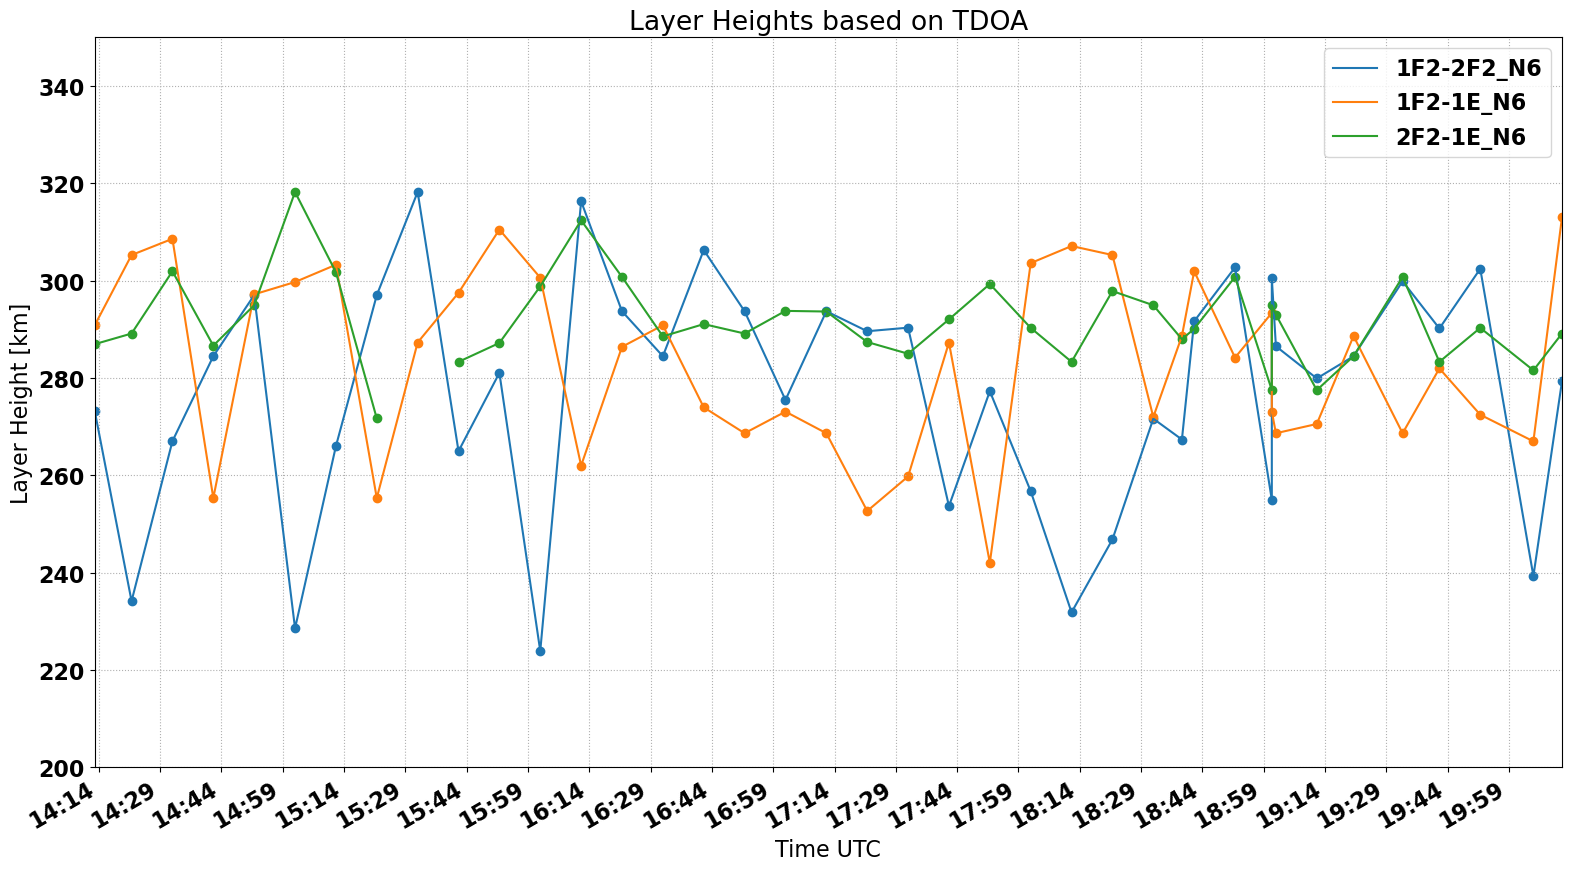

In [31]:
plothmf2(TDOAs_sets=[N6_TDOAs_F, N6_TDOAs_E, N6_TDOAs_], set_names=['1F2-2F2_N6', '1F2-1E_N6', '2F2-1E_N6'], times=N6RFM5band_times)

Alrighty, time to overlay Austin Ionosonde at least HMF2

In [35]:
import datetime as dt

IonosondeLayer_Height = [263, 258.2, 253.2, 246.7, 249.7, 254.8, 249.8, 253, 252, 265.7, 275.6, 279.7, 275.5, 277.7, 279.2, 270.8, 263.5, 265.8, 283.6, 286, 298.1, 295.5, 297.2, 292.7, 295.6, 299.7, 296.4, 293, 288.3, 284.5, 280.7, 285, 298.6, 287.8, 286.5, 279.3, 283.8, 296.8, 289.1, 300.3, 291.9, 288.9, 300.4, 295.8, 289.4, 292, 300.7, 290.9, 307.4, 304.7, 292.8, 302.3, 313.6, 308.7, 300, 291.7, 302.4, 303.7, 301, 306.2, 298.3, 284.9, 291.4, 293.8, 292.5, 302.4, 286.6, 285.9, 276.5, 288, 286.5, 278.9, 275.9, 270.6, 280.7, 276.1, 273.1, 275.7, 279.2, 299.5, 290.9, 285.8, 278.9, 281, 288.8, 279.9, 281, 277.4, 277, 271.5, 276.9]
Ionosonde_times = [
    "14:00:05", "14:05:05", "14:10:05", "14:15:05", "14:20:05", "14:25:05", "14:30:05", "14:35:05", "14:40:05", "14:45:05",
    "14:50:05", "14:55:05", "15:00:05", "15:05:05", "15:10:05", "15:15:05", "15:20:05", "15:25:05", "15:30:05", "15:35:05",
    "15:40:05", "15:45:05", "15:50:05", "15:55:05", "16:00:05", "16:05:05", "16:10:05", "16:15:05", "16:20:05", "16:25:05",
    "16:30:05", "16:35:05", "16:40:05", "16:45:05", "16:50:05", "16:55:05", "17:00:05", "17:05:05", "17:10:05", "17:15:05",
    "17:20:05", "17:25:05", "17:30:05", "17:35:05", "17:40:05", "17:45:05", "17:50:05", "17:55:05", "18:00:05", "18:05:05",
    "18:10:05", "18:15:05", "18:20:05", "18:25:05", "18:30:05", "18:35:05", "18:40:05", "18:45:05", "18:50:05", "18:55:05",
    "19:00:05", "19:05:05", "19:10:05", "19:15:05", "19:20:05", "19:25:05", "19:30:05", "19:35:05", "19:40:05", "19:45:05",
    "19:50:05", "19:55:05", "20:00:05", "20:05:05", "20:10:05", "20:15:05", "20:20:05", "20:25:05", "20:30:05", "20:35:05",
    "20:40:05", "20:45:05", "20:50:05", "20:55:05", "21:00:05", "21:05:05", "21:10:05", "21:15:05", "21:20:05", "21:25:05",
    "21:30:05"
]
date_str = "2024-04-08"
Ionosonde_datetimes = [dt.datetime.strptime(date_str + " " + time_str, "%Y-%m-%d %H:%M:%S") for time_str in Ionosonde_times]
print(Ionosonde_datetimes)

[datetime.datetime(2024, 4, 8, 14, 0, 5), datetime.datetime(2024, 4, 8, 14, 5, 5), datetime.datetime(2024, 4, 8, 14, 10, 5), datetime.datetime(2024, 4, 8, 14, 15, 5), datetime.datetime(2024, 4, 8, 14, 20, 5), datetime.datetime(2024, 4, 8, 14, 25, 5), datetime.datetime(2024, 4, 8, 14, 30, 5), datetime.datetime(2024, 4, 8, 14, 35, 5), datetime.datetime(2024, 4, 8, 14, 40, 5), datetime.datetime(2024, 4, 8, 14, 45, 5), datetime.datetime(2024, 4, 8, 14, 50, 5), datetime.datetime(2024, 4, 8, 14, 55, 5), datetime.datetime(2024, 4, 8, 15, 0, 5), datetime.datetime(2024, 4, 8, 15, 5, 5), datetime.datetime(2024, 4, 8, 15, 10, 5), datetime.datetime(2024, 4, 8, 15, 15, 5), datetime.datetime(2024, 4, 8, 15, 20, 5), datetime.datetime(2024, 4, 8, 15, 25, 5), datetime.datetime(2024, 4, 8, 15, 30, 5), datetime.datetime(2024, 4, 8, 15, 35, 5), datetime.datetime(2024, 4, 8, 15, 40, 5), datetime.datetime(2024, 4, 8, 15, 45, 5), datetime.datetime(2024, 4, 8, 15, 50, 5), datetime.datetime(2024, 4, 8, 15, 55,

In [36]:
IonosondeLayer_HeighthmE = [101.2, 101, 110, 97.2, 97.4, 97.1, 89.6, 90.3, 110, 98.7, 110, 91.5, 88.5, 90, 102.3, 97.7, 89.8, 110, 100, 90.8, 93.8, 93.1, 110, 107.2, 110, 119.1, 97.2, 97, 101.5, 100.8, 108.4, 110, 110, 110, 101.1, 110, 103.4, 96.5, 110, 120.5, 110, 110, 101.2, 111, 110, 110, 110, 110, 97.5, 90.3, 97.8, 110, 105.3, 113.8, 119.6, 110, 110, 116.1, 108.6, 110, 110, 114.5, 100.9, 99.4, 93.7, 110, 120.2, 85.8, 93.4, 89.6, 110, 107.3, 110, 110, 101.9, 123.3, 93.6, 110, 99.1, 110, 105.3, 95.5, 118.5, 95.6, 110, 110, 108.6, 101.6, 93.3, 102.5, 110]
Ionosonde_timeshmE = [
    "14:00:05", "14:05:05", "14:10:05", "14:15:05", "14:20:05", "14:25:05", "14:30:05", "14:35:05", "14:40:05", "14:45:05",
    "14:50:05", "14:55:05", "15:00:05", "15:05:05", "15:10:05", "15:15:05", "15:20:05", "15:25:05", "15:30:05", "15:35:05",
    "15:40:05", "15:45:05", "15:50:05", "15:55:05", "16:00:05", "16:05:05", "16:10:05", "16:15:05", "16:20:05", "16:25:05",
    "16:30:05", "16:35:05", "16:40:05", "16:45:05", "16:50:05", "16:55:05", "17:00:05", "17:05:05", "17:10:05", "17:15:05",
    "17:20:05", "17:25:05", "17:30:05", "17:35:05", "17:40:05", "17:45:05", "17:50:05", "17:55:05", "18:00:05", "18:05:05",
    "18:10:05", "18:15:05", "18:20:05", "18:25:05", "18:30:05", "18:35:05", "18:40:05", "18:45:05", "18:50:05", "18:55:05",
    "19:00:05", "19:05:05", "19:10:05", "19:15:05", "19:20:05", "19:25:05", "19:30:05", "19:35:05", "19:40:05", "19:45:05",
    "19:50:05", "19:55:05", "20:00:05", "20:05:05", "20:10:05", "20:15:05", "20:20:05", "20:25:05", "20:30:05", "20:35:05",
    "20:40:05", "20:45:05", "20:50:05", "20:55:05", "21:00:05", "21:05:05", "21:10:05", "21:15:05", "21:20:05", "21:25:05",
    "21:30:05"
]

date_str = "2024-04-08"
Ionosonde_datetimeshmE = [dt.datetime.strptime(date_str + " " + time_str, "%Y-%m-%d %H:%M:%S") for time_str in Ionosonde_timeshmE]
print(len(Ionosonde_datetimeshmE))
print(len(Ionosonde_timeshmE))
print(len(IonosondeLayer_HeighthmE))

91
91
91


In [37]:
def plothmf2V2(TDOAs_sets, set_names, times, grnd):
    
    times = np.array(times)    
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(1, 1, 1)
    
    miny = 75
    maxy = 450   
    for TDOAs, set_name in zip(TDOAs_sets, set_names):
        TDOAs = np.nanmean(TDOAs, axis=1)

        
        if set_name == '1F2-2F2_N6':
            layer_heights = (140.2 * TDOAs) + 48.3
            linestyle = '--'
            linewidth = 3
        elif set_name == '1F2-1E_N6':
            layer_heights = (181.8 * TDOAs) + 135.5
            linestyle = '-.'
            linewidth = 1.5
        elif set_name == '2F2-1E_N6':
            layer_heights = (79.4 * TDOAs) + 85.6
            linestyle = ':'
            linewidth = 2.5
        
        if set_name == '1F2-2F2_N5':
            layer_heights = (142 * TDOAs) + 36.1
            linestyle = '--'
            linewidth = 3
        elif set_name == '1F2-1E_N5':
            layer_heights = (170.4 * TDOAs) + 126.1
            linestyle = '-.'
            linewidth = 1.5
        elif set_name == '2F2-1E_N5':
            layer_heights = (77.7 * TDOAs) + 75.8
            linestyle = ':'
            linewidth = 2.5
        
        if set_name == '1F2-2F2_AB':
            layer_heights = (150 * TDOAs) 
            linestyle = '--'
            linewidth = 3
        elif set_name == '1F2-1E_AB':
            layer_heights = 150 * (TDOAs + 0.7)
            linestyle = '-.'
            linewidth = 1.5
        
        ax.scatter(times, layer_heights)
        ax.plot(times, layer_heights, label=set_name, linestyle = linestyle, linewidth = linewidth)
        
        
        
        ax.set_ylim(miny, maxy)
    
    myFmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
    ax.set_ylabel('Layer Height [km]')
    ax.set_xlabel('Time UTC')
    ax.set_title('Layer Heights based on TDOA from Tx: WA5FRF Rx: ' + grnd)
    
    # ax.scatter(Ionosonde_datetimes, IonosondeLayer_Height, color = 'purple')
    ax.plot(Ionosonde_datetimes,IonosondeLayer_Height, color = 'purple', label = "Austin Ionosonde hmf2", linewidth = 2)
    ax.plot(Ionosonde_datetimeshmE,IonosondeLayer_HeighthmE, color = 'brown', label = "Austin Ionosonde hmE", linewidth = 2)
    # ax.set_xlim(datetime(2024, 4, 8, 14),datetime(2024, 4, 8, 20, 30))
    ax.legend()
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

C:\Users\alexp\AppData\Local\Temp\ipykernel_9148\902809898.py:10: RuntimeWarning: Mean of empty slice
  TDOAs = np.nanmean(TDOAs, axis=1)


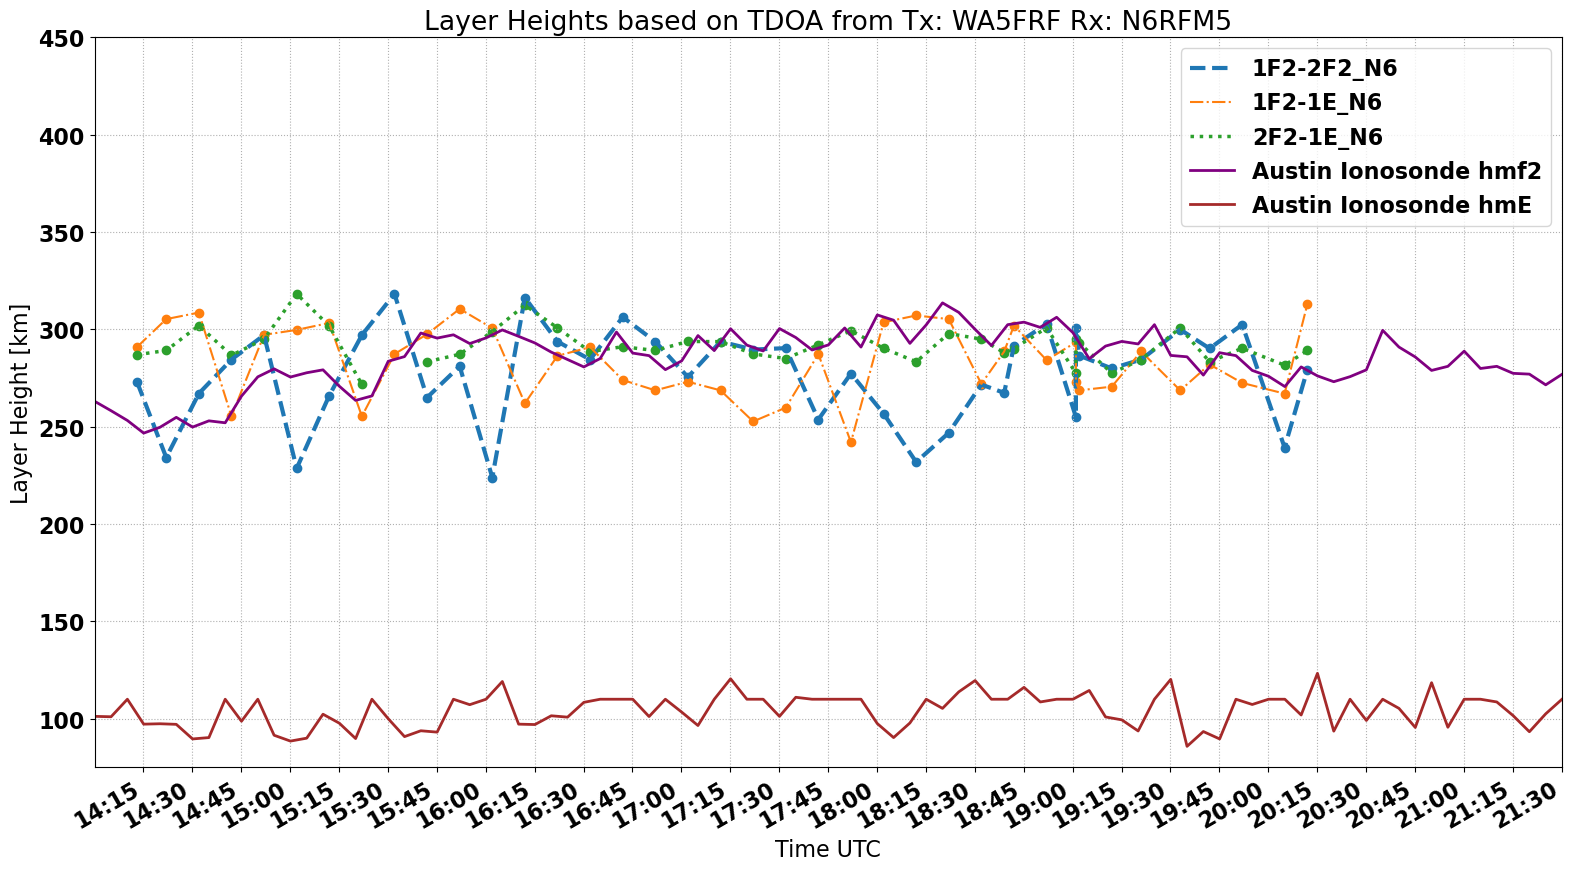

In [38]:
plothmf2V2(TDOAs_sets=[N6_TDOAs_F, N6_TDOAs_E, N6_TDOAs_], set_names=['1F2-2F2_N6', '1F2-1E_N6', '2F2-1E_N6'], times=N6RFM5band_times, grnd = 'N6RFM5')
#plothmf2V2(TDOAs_sets=[N5DUP40_TDOAs_F, N5DUP40_TDOAs_E, N5DUP40_TDOAs_], set_names=['1F2-2F2_N5', '1F2-1E_N5', '2F2-1E_N5'], times=N5DUP40band_times, grnd = 'N5DUP')
# plothmf2V2(TDOAs_sets=[N5DUP_TDOAs_F, N5DUP_TDOAs_E, N5DUP_TDOAs_], set_names=['1F2-2F2_N5', '1F2-1E_N5', '2F2-1E_N5'], times=N5DUP60band_times, grnd = 'N5DUP')

#plothmf2V2(TDOAs_sets=[AB40_TDOAS_F, AB40_TDOAS_E], set_names=['1F2-2F2_AB', '1F2-1E_AB'], times=AB40band_times, grnd = 'AB5YO')
#plothmf2V2(TDOAs_sets=[N5DUP_TDOAs_F, N5DUP_TDOAs_E, N5DUP_TDOAs_], set_names=['1F2-2F2_N5', '1F2-1E_N5', '2F2-1E_N5'], times=N5DUP60band_times, grnd = 'N5DUP')

#SLIDE 37 controlling images Chapter 5 RACE AND ETHNIC RELATIONS

In [29]:
def plothmf2N5(TDOAs_sets, set_names, times, grnd):
    
    times = np.array(times)    
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(1, 1, 1)
    
    miny = 75
    maxy = 600
    
    for TDOAs, set_name in zip(TDOAs_sets, set_names):
        TDOAs = np.nanmean(TDOAs, axis=1)

        
        if set_name == '1F2-2F2':
            layer_heights = (142 * TDOAs) + 36.1
            linestyle = '--'
            linewidth = 3
        elif set_name == '1F2-1E':
            layer_heights = (170.4 * TDOAs) + 126.1
            linestyle = '-.'
            linewidth = 1.5
        elif set_name == '2F2-1E':
            layer_heights = (169.5 * TDOAs) + 129.7
            linestyle = ':'
            linewidth = 2.5
        
        ax.scatter(times, layer_heights)
        ax.plot(times, layer_heights, label=set_name, linestyle = linestyle, linewidth = linewidth)
        
        ax.set_ylim(miny, maxy)
    
    myFmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
    ax.set_ylabel('Layer Height [km]')
    ax.set_xlabel('Time UTC')
    ax.set_title('Layer Heights based on TDOA from Tx: WA5FRF Rx: ' + grnd)
    
    # # ax.scatter(Ionosonde_datetimes, IonosondeLayer_Height, color = 'purple')
    # ax.plot(Ionosonde_datetimes,IonosondeLayer_Height, color = 'purple', label = "Austin Ionosonde hmf2", linewidth = 2)
    # # ax.set_xlim(datetime(2024, 4, 8, 14),datetime(2024, 4, 8, 20, 30))
    # ax.legend()
    # fig.autofmt_xdate()
    # plt.tight_layout()
    # plt.show()
    
    ax.plot(Ionosonde_datetimes,IonosondeLayer_Height, color = 'purple', label = "Austin Ionosonde hmf2", linewidth = 2)
    ax.plot(Ionosonde_datetimeshmE,IonosondeLayer_HeighthmE, color = 'brown', label = "Austin Ionosonde hmE", linewidth = 2)
    # ax.set_xlim(datetime(2024, 4, 8, 14),datetime(2024, 4, 8, 20, 30))
    ax.legend()
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

C:\Users\alexp\AppData\Local\Temp\ipykernel_17568\1039625005.py:11: RuntimeWarning: Mean of empty slice
  TDOAs = np.nanmean(TDOAs, axis=1)


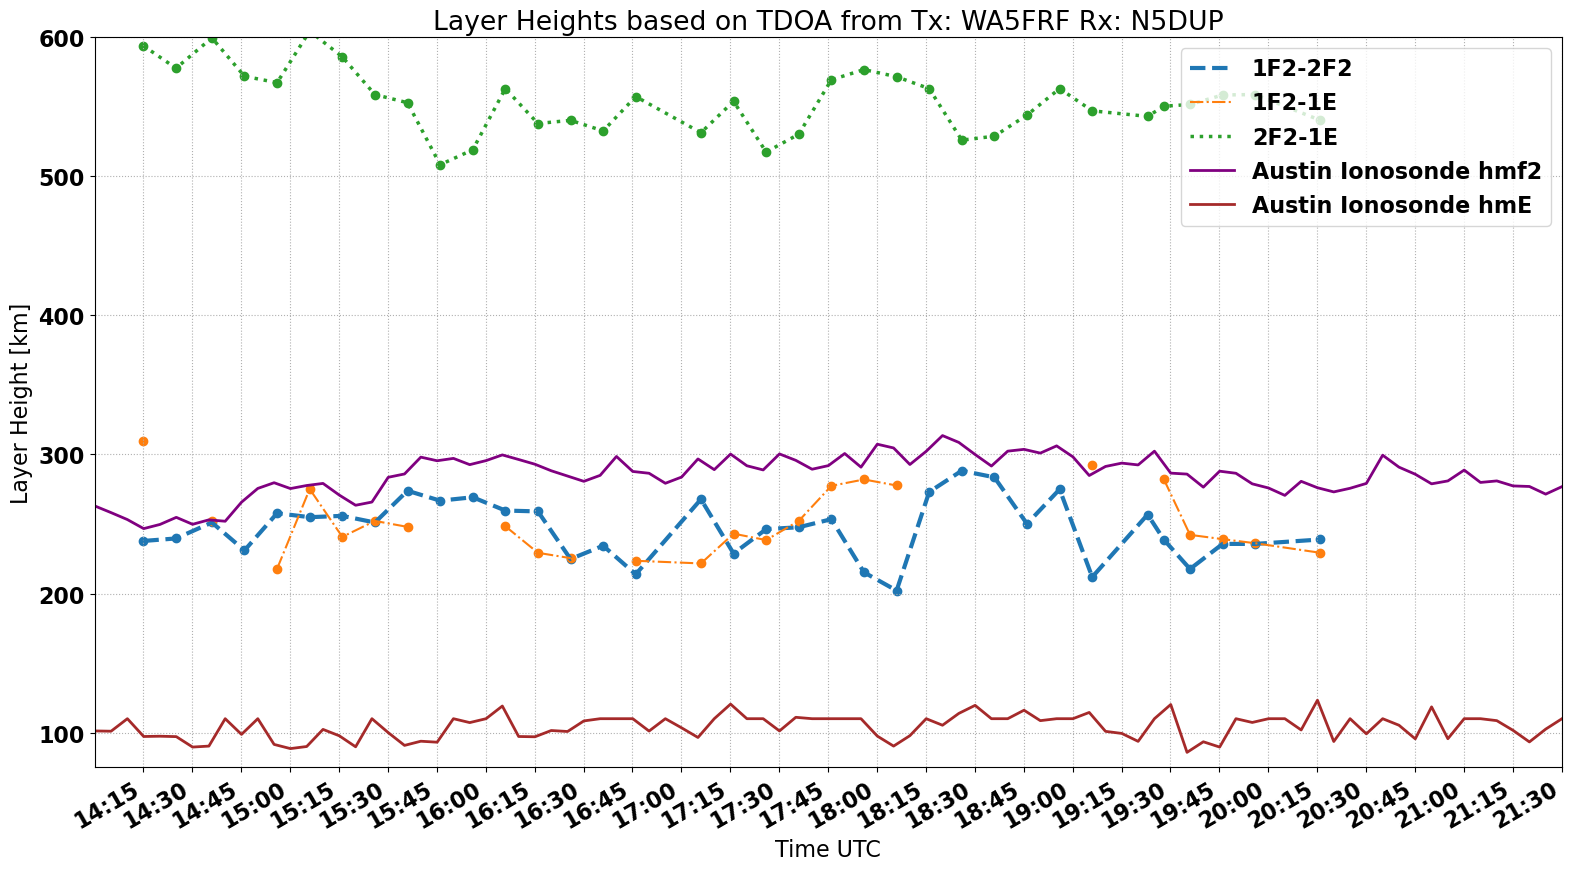

[[2.69165039 2.55706787 2.69165039 2.75894165 2.75894165 2.75894165
  2.82623291 2.82623291 2.75894165 2.75894165]
 [2.62435913 2.42248535 2.55706787 2.75894165 2.75894165 2.48977661
  2.89352417        nan        nan        nan]
 [2.89352417 2.89352417 2.42248535 2.82623291 2.75894165 2.62435913
  2.75894165 2.89352417 2.89352417 2.75894165]
 [2.75894165 2.82623291 2.48977661 2.89352417        nan 2.28790283
  2.69165039 2.48977661 2.48977661 2.55706787]
 [2.35519409 2.48977661 2.48977661 2.89352417 2.62435913        nan
         nan 2.62435913 2.55706787 2.62435913]
 [2.42248535 2.96081543 2.89352417 2.89352417        nan 2.96081543
  2.75894165 2.69165039 2.82623291        nan]
 [2.48977661 2.42248535 2.69165039 2.89352417        nan 2.82623291
  2.62435913 2.69165039 2.69165039 2.89352417]
 [       nan 2.35519409        nan 2.89352417 2.42248535 2.42248535
  2.22061157 2.96081543 2.35519409 2.62435913]
 [2.62435913 2.62435913 2.62435913 2.69165039        nan 2.28790283
  2.28790283

In [30]:
plothmf2N5(TDOAs_sets = [N5DUP_TDOAs_F, N5DUP_TDOAs_E, N5DUP_TDOAs_], set_names=['1F2-2F2', '1F2-1E', '2F2-1E'], times = N5DUP60band_times, grnd= 'N5DUP')
print(N5DUP_TDOAs_)